In [33]:
import pandas as pd
import numpy as np
import glob
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
#df1: tax rev
df1 = pd.read_csv(
   '/Users/apple/Downloads/1. DatathonMasterStateTaxData_2004_2025Q2.csv',
    encoding='utf-8',
    low_memory=False
)

#df2: economic indicator
df2 = pd.read_csv(
   '/Users/apple/Downloads/2. DatathonMasterEconomicDataset_2004_2025Q2.csv',
    encoding='utf-8',
    low_memory=False
)

#df3: demographic indicators
df3 = pd.read_csv(
   '/Users/apple/Downloads/3. (optional) DatathonAnnualDemographicsDataset.csv',
    encoding='utf-8',
    low_memory=False
)

In [35]:
#df1.info()
#df2.info()

In [36]:
state_merge = df1.merge(df2, left_on=['State', 'Year','Quarter'], right_on=['State', 'Year','Quarter'], how='left')
state_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111800 entries, 0 to 111799
Data columns (total 45 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Year                                   111800 non-null  int64  
 1   Quarter                                111800 non-null  int64  
 2   State                                  111800 non-null  object 
 3   Tax_Category                           111800 non-null  object 
 4   Tax_Code                               111800 non-null  object 
 5   Amount                                 111800 non-null  float64
 6   Population                             104550 non-null  float64
 7   Unemployment_Rate                      104550 non-null  float64
 8   Civilian noninstitutional population   104550 non-null  float64
 9   Total Civilian Labor Force             104550 non-null  float64
 10  Total Employed Civilian Labor Force    104550 non-null  

In [37]:
# Step 1: Identify states with income tax (non-tax haven states)
# Major states with NO income tax: Texas, Florida, Nevada, Washington, Wyoming, South Dakota, Tennessee (limited), Alaska, New Hampshire (limited)

tax_haven_states = ['Texas', 'Florida', 'Wyoming']

# States that definitely have income tax (excluding tax havens)
# We'll find all states and exclude known no-income-tax states
no_income_tax_states = ['Texas', 'Florida', 'Nevada', 'Washington', 'Wyoming',
                        'South Dakota', 'Tennessee', 'Alaska', 'New Hampshire']

In [38]:
# Step 2: Calculate average GDP in 2014 for tax haven states
def calc_gdp(df, year=2014):
    """
    Find states with similar GDP to target states
    """
    # Filter for 2014 data
    df_2014 = df[df['Year'] == year].copy()

    # Get unique states and their GDP
    state_gdp = df_2014.groupby('State')['GDP_Total'].mean().reset_index()
    state_gdp.columns = ['State', 'GDP_2014']
    state_gdp = state_gdp.sort_values('GDP_2014', ascending=False)

    print("=" * 80)
    print(f"GDP Rankings for {year}")
    print("=" * 80)
    print(state_gdp.to_string(index=False))
    print("\n")

    return state_gdp

In [39]:
gdp = calc_gdp(state_merge, year=2014)

GDP Rankings for 2014
               State    GDP_2014
          California 2342218.800
               Texas 1592177.650
            New York 1434606.275
             Florida  860112.625
            Illinois  772291.750
        Pennsylvania  695546.650
                Ohio  597152.350
          New Jersey  543824.150
             Georgia  493370.275
      North Carolina  482295.650
       Massachusetts  469824.900
            Virginia  465601.700
            Michigan  456123.475
          Washington  439851.225
            Maryland  351743.125
             Indiana  329360.900
           Minnesota  324701.500
            Colorado  309223.900
           Tennessee  307448.500
           Wisconsin  296169.925
            Missouri  289340.725
             Arizona  286675.975
         Connecticut  247114.700
           Louisiana  240965.025
            Oklahoma  197074.125
             Alabama  197064.400
      South Carolina  195744.400
            Kentucky  188326.400
              Oregon 

In [40]:
state_pairs = {
    'Texas': 'New York',
    'Florida': 'Illinois',
    'Wyoming': 'Montana'
}

In [41]:
# METRIC CONFIGURATIONS
# Define what metrics you want to analyze and how to display them
METRICS = {
    'Total_Tax_Revenue': {
        'column': 'Amount',
        'aggregation': 'sum',
        'title': 'Total Tax Revenue',
        'ylabel': 'Tax Revenue ($)',
        'format': lambda x, p: f'${x/1e9:.1f}B' if x >= 1e9 else f'${x/1e6:.0f}M'
    },
    'GDP_Total': {
        'column': 'GDP_Total',
        'aggregation': 'sum',
        'title': 'GDP Total',
        'ylabel': 'GDP ($)',
        'format': lambda x, p: f'${x/1e9:.1f}B' if x >= 1e9 else f'${x/1e6:.0f}M'
    },
    'Population': {
        'column': 'Population',
        'aggregation': 'mean',
        'title': 'Population',
        'ylabel': 'Population',
        'format': lambda x, p: f'{x/1e6:.2f}M'
    },
    'Unemployment_Rate': {
        'column': 'Unemployment_Rate',
        'aggregation': 'mean',
        'title': 'Unemployment Rate',
        'ylabel': 'Unemployment Rate (%)',
        'format': lambda x, p: f'{x:.1f}%'
    },
    'Formations': {
        'column': 'Formations',
        'aggregation': 'sum',  # Total business formations per year
        'title': 'Business Formations',
        'ylabel': 'Number of Formations',
        'format': lambda x, p: f'{x/1e3:.0f}K' if x >= 1e3 else f'{x:.0f}'
    },
    'Housing_Price_Index': {
        'column': 'Housing_Price_Index',
        'aggregation': 'mean',
        'title': 'Housing Price Index',
        'ylabel': 'Housing Price Index',
        'format': lambda x, p: f'{x:.1f}'
    },
    'Personal_Income': {
        'column': 'Personal_Income',
        'aggregation': 'mean',
        'title': 'Personal Income',
        'ylabel': 'Personal Income ($)',
        'format': lambda x, p: f'${x/1e9:.1f}B' if x >= 1e9 else f'${x/1e6:.0f}M'
    },
    'GDP_Per_Capita': {
        'column': 'GDP_Per_Capita',  # Will be calculated
        'aggregation': 'calculated',  # Special handling
        'title': 'GDP Per Capita',
        'ylabel': 'GDP Per Capita ($)',
        'format': lambda x, p: f'${x/1e3:.1f}K' if x >= 1e3 else f'${x:.0f}'
    },
    'Total Civilian Labor Force': {
        'column': 'Total Civilian Labor Force',
        'aggregation': 'sum',
        'title': 'Total Civilian Labor Force',
        'ylabel': 'Total Civilian Labor Force',
        'format': lambda x, p: f'{x:,.0f}',  # Format with commas, no decimals
    }
}

In [42]:
def calculate_metric_by_year(df, states, metric_name, year_range=(2014, 2024)):
    """
    Calculate any metric by state and year

    Parameters:
    -----------
    df : DataFrame
        The main dataframe
    states : list
        List of states to include
    metric_name : str
        Name of the metric from METRICS dictionary
    year_range : tuple
        (start_year, end_year)

    Returns:
    --------
    DataFrame with columns: State, Year, {metric_name}
    """
    if metric_name not in METRICS:
        raise ValueError(f"Metric '{metric_name}' not found. Available: {list(METRICS.keys())}")

    metric_config = METRICS[metric_name]
    column = metric_config['column']
    aggregation = metric_config['aggregation']

    # Filter for year range
    df_filtered = df[(df['Year'] >= year_range[0]) & (df['Year'] <= year_range[1])].copy()

    # Special handling for GDP Per Capita (calculated metric)
    if metric_name == 'GDP_Per_Capita':
        # Calculate GDP per capita = GDP_Total / Population
        # First get averages of GDP and Population by State and Year
        gdp_avg = df_filtered.groupby(['State', 'Year'])['GDP_Total'].mean().reset_index()
        pop_avg = df_filtered.groupby(['State', 'Year'])['Population'].mean().reset_index()

        # Merge and calculate per capita
        result = gdp_avg.merge(pop_avg, on=['State', 'Year'])
        result['GDP_Per_Capita'] = (result['GDP_Total'] * 1_000_000) / result['Population']  # GDP is in millions, so multiply by 1M
        result = result[['State', 'Year', 'GDP_Per_Capita']]
        result.columns = ['State', 'Year', metric_name]
    else:
        # Group by State and Year
        if aggregation == 'sum':
            result = df_filtered.groupby(['State', 'Year'])[column].sum().reset_index()
        elif aggregation == 'mean':
            result = df_filtered.groupby(['State', 'Year'])[column].mean().reset_index()
        elif aggregation == 'median':
            result = df_filtered.groupby(['State', 'Year'])[column].median().reset_index()
        else:
            raise ValueError(f"Unknown aggregation: {aggregation}")

        result.columns = ['State', 'Year', metric_name]

    # Filter for our states of interest
    result = result[result['State'].isin(states)]

    return result

In [43]:
def plot_single_metric(df, state_pairs, metric_name, year_range=(2014, 2024), save_path=None):
    """
    Create comparison plots for a single metric

    Parameters:
    -----------
    df : DataFrame
        The main dataframe
    state_pairs : dict
        Dictionary mapping tax haven states to comparison states
    metric_name : str
        Name of the metric to plot (must be in METRICS dictionary)
    year_range : tuple
        (start_year, end_year)
    save_path : str, optional
        Path to save the figure. If None, uses default naming

    Returns:
    --------
    DataFrame with the metric data
    """
    if metric_name not in METRICS:
        raise ValueError(f"Metric '{metric_name}' not found. Available: {list(METRICS.keys())}")

    metric_config = METRICS[metric_name]

    # Calculate metric data
    all_states = list(state_pairs.keys()) + list(state_pairs.values())
    metric_data = calculate_metric_by_year(df, all_states, metric_name, year_range)

    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    fig.suptitle(f'{metric_config["title"]} Comparison: Tax Haven vs Income Tax States ({year_range[0]}-{year_range[1]})',
                 fontsize=16, fontweight='bold', y=0.995)

    colors_haven = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    colors_income = ['#d62728', '#9467bd', '#8c564b']  # Red, Purple, Brown

    for idx, (haven_state, income_state) in enumerate(state_pairs.items()):
        ax = axes[idx]

        # Get data for both states
        haven_data = metric_data[metric_data['State'] == haven_state].sort_values('Year')
        income_data = metric_data[metric_data['State'] == income_state].sort_values('Year')

        # Check if data exists
        if len(haven_data) == 0:
            print(f"Warning: No data found for {haven_state}")
            ax.text(0.5, 0.5, f'No data available for {haven_state}',
                   ha='center', va='center', transform=ax.transAxes)
            continue
        if len(income_data) == 0:
            print(f"Warning: No data found for {income_state}")
            ax.text(0.5, 0.5, f'No data available for {income_state}',
                   ha='center', va='center', transform=ax.transAxes)
            continue

        # Plot lines
        ax.plot(haven_data['Year'], haven_data[metric_name],
                marker='o', linewidth=2.5, markersize=8,
                label=f'{haven_state} (No Income Tax)',
                color=colors_haven[idx])

        ax.plot(income_data['Year'], income_data[metric_name],
                marker='s', linewidth=2.5, markersize=8,
                label=f'{income_state} (Has Income Tax)',
                color=colors_income[idx], linestyle='--')

        # Formatting
        ax.set_xlabel('Year', fontsize=11, fontweight='bold')
        ax.set_ylabel(metric_config['ylabel'], fontsize=11, fontweight='bold')
        ax.set_title(f'{haven_state} vs {income_state}', fontsize=13, fontweight='bold', pad=10)
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.ticklabel_format(style='plain', axis='y')

        # Format y-axis
        ax.yaxis.set_major_formatter(plt.FuncFormatter(metric_config['format']))

        # Set x-axis to show all years
        ax.set_xticks(range(year_range[0], year_range[1] + 1))
        ax.set_xticklabels(range(year_range[0], year_range[1] + 1), rotation=45)

    plt.tight_layout()

    return metric_data

State  Year  Total_Tax_Revenue
99   Florida  2014         37635823.0
100  Florida  2015         38536718.0
101  Florida  2016         40406232.0
102  Florida  2017         43256137.0
103  Florida  2018         44421054.0
..       ...   ...                ...
567  Wyoming  2020          2000226.0
568  Wyoming  2021          1988160.0
569  Wyoming  2022          2748497.0
570  Wyoming  2023          2853407.0
571  Wyoming  2024          2574260.0

[66 rows x 3 columns]

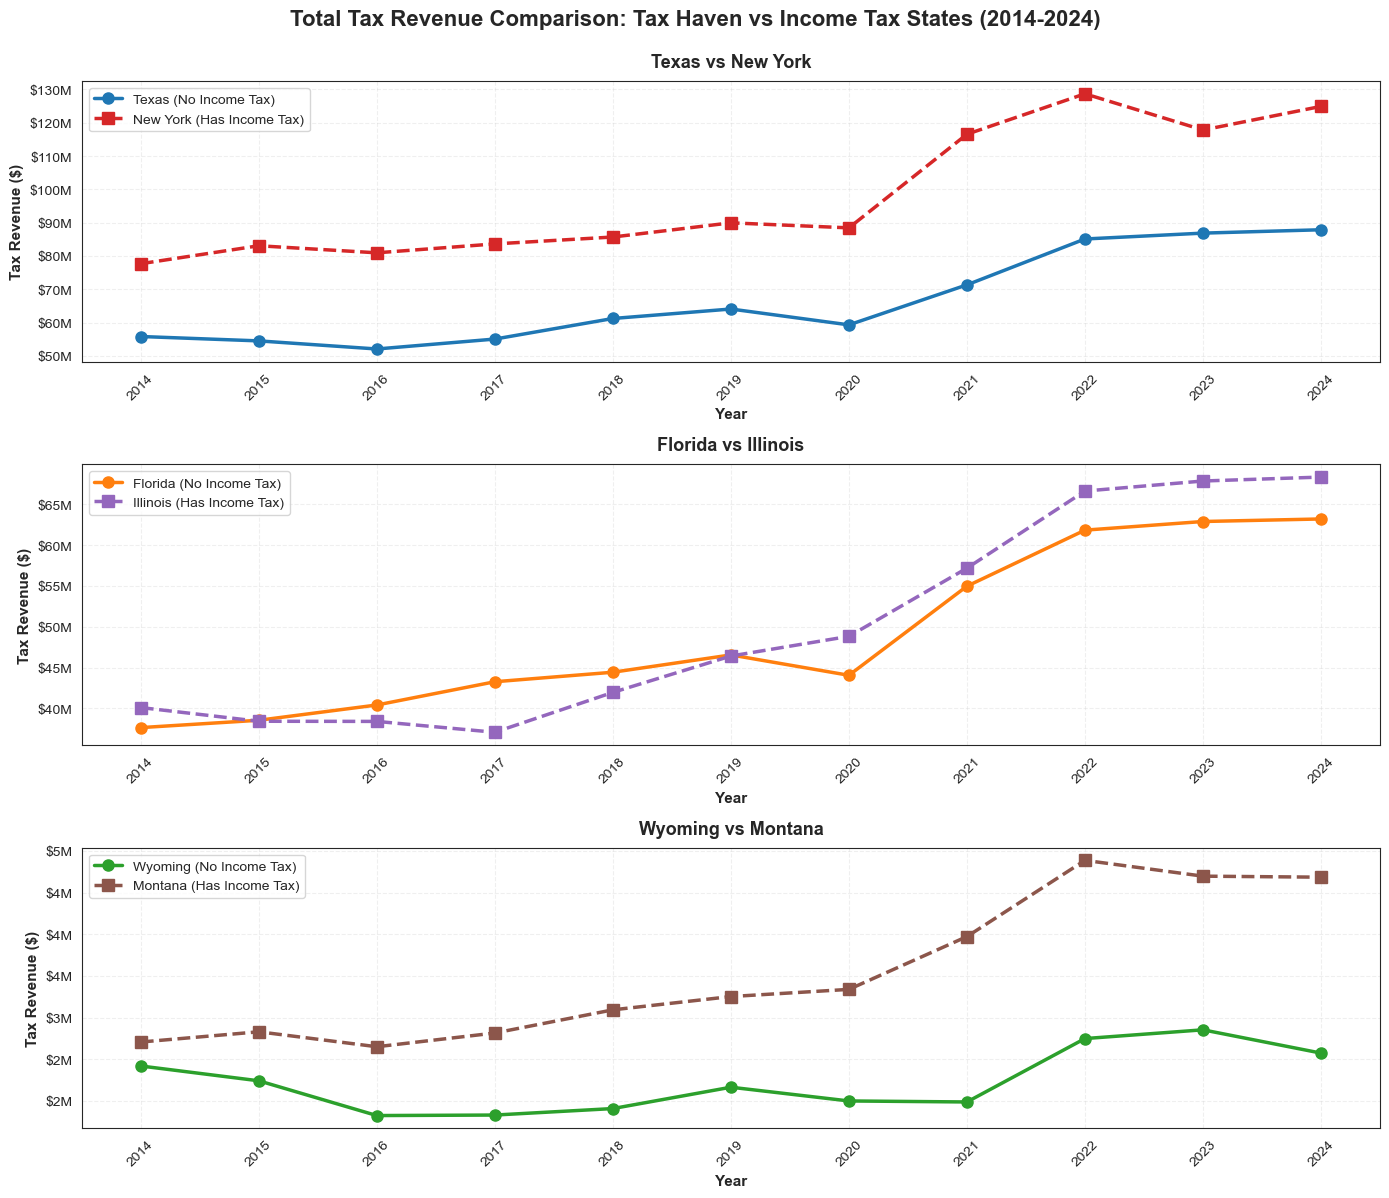

In [44]:
plot_single_metric(state_merge, state_pairs, 'Total_Tax_Revenue', year_range=(2014, 2024), save_path=None)

State  Year    GDP_Total
99   Florida  2014   86011262.5
100  Florida  2015   91846432.5
101  Florida  2016   96450085.0
102  Florida  2017  101486685.0
103  Florida  2018  107208557.5
..       ...   ...          ...
567  Wyoming  2020    3698270.0
568  Wyoming  2021    4241055.0
569  Wyoming  2022    4957035.0
570  Wyoming  2023    5135007.5
571  Wyoming  2024    5149815.0

[66 rows x 3 columns]

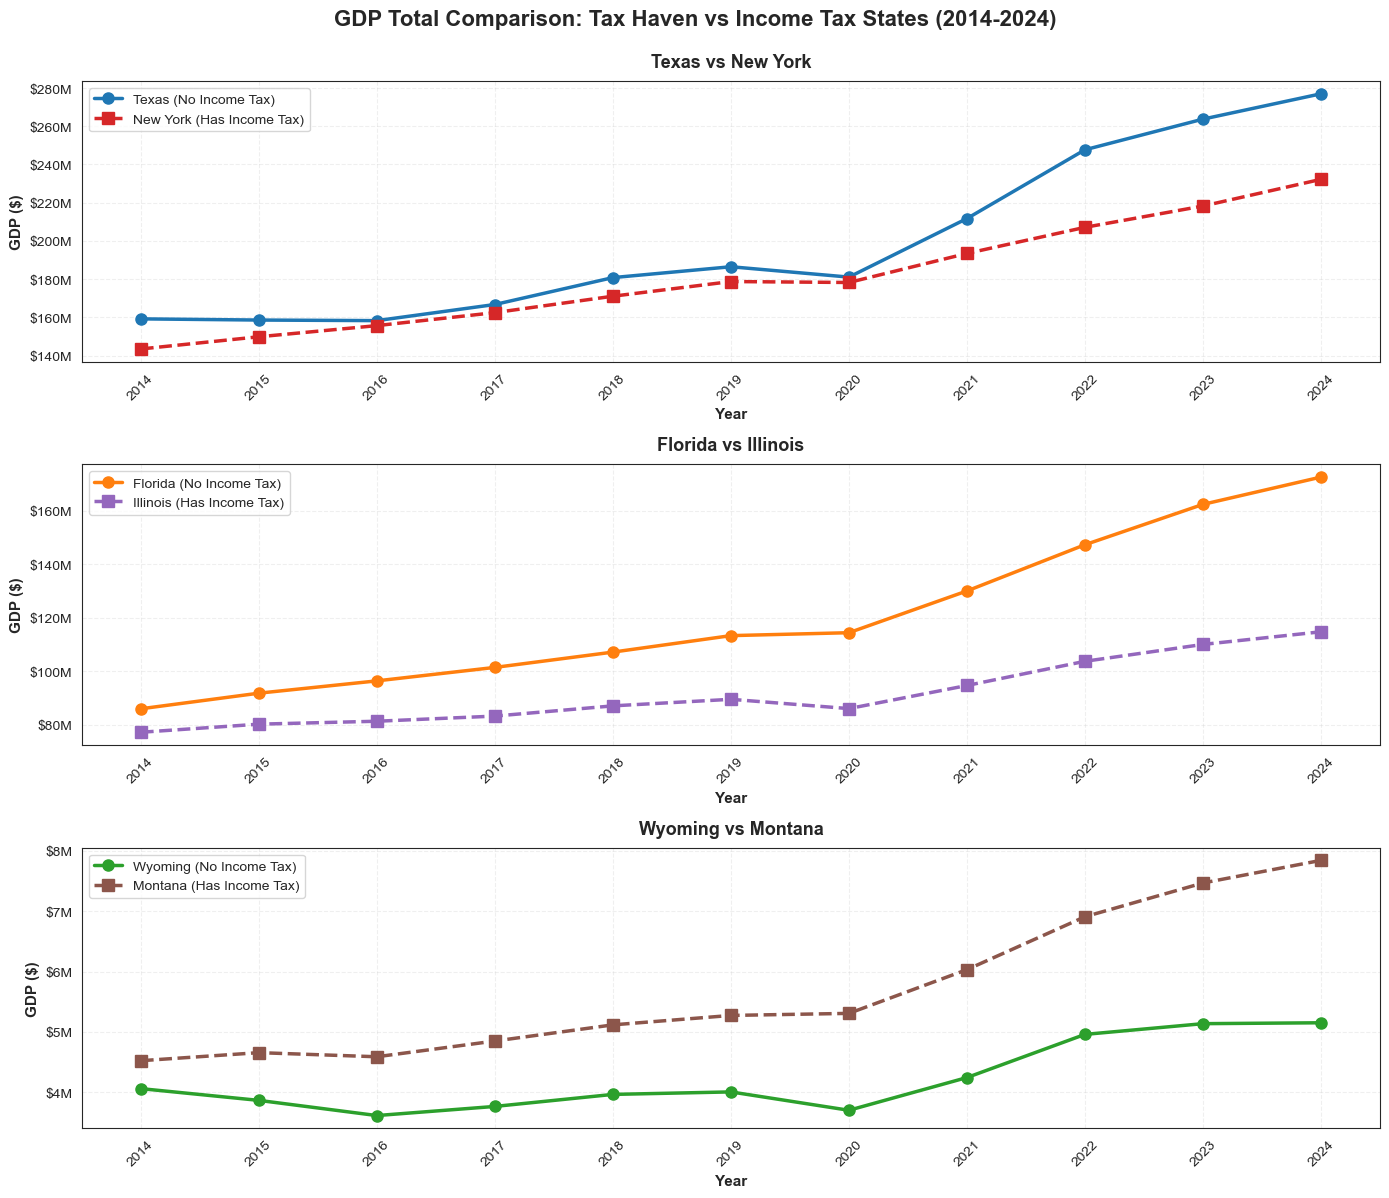

In [45]:
plot_single_metric(state_merge, state_pairs, 'GDP_Total', year_range=(2014, 2024), save_path=None)

State  Year  GDP_Per_Capita
99   Florida  2014    43432.766997
100  Florida  2015    45580.816574
101  Florida  2016    46978.412769
102  Florida  2017    48641.642323
103  Florida  2018    50736.668863
..       ...   ...             ...
567  Wyoming  2020    64027.056295
568  Wyoming  2021    73166.894178
569  Wyoming  2022    85165.435310
570  Wyoming  2023    87772.917180
571  Wyoming  2024    87645.796148

[66 rows x 3 columns]

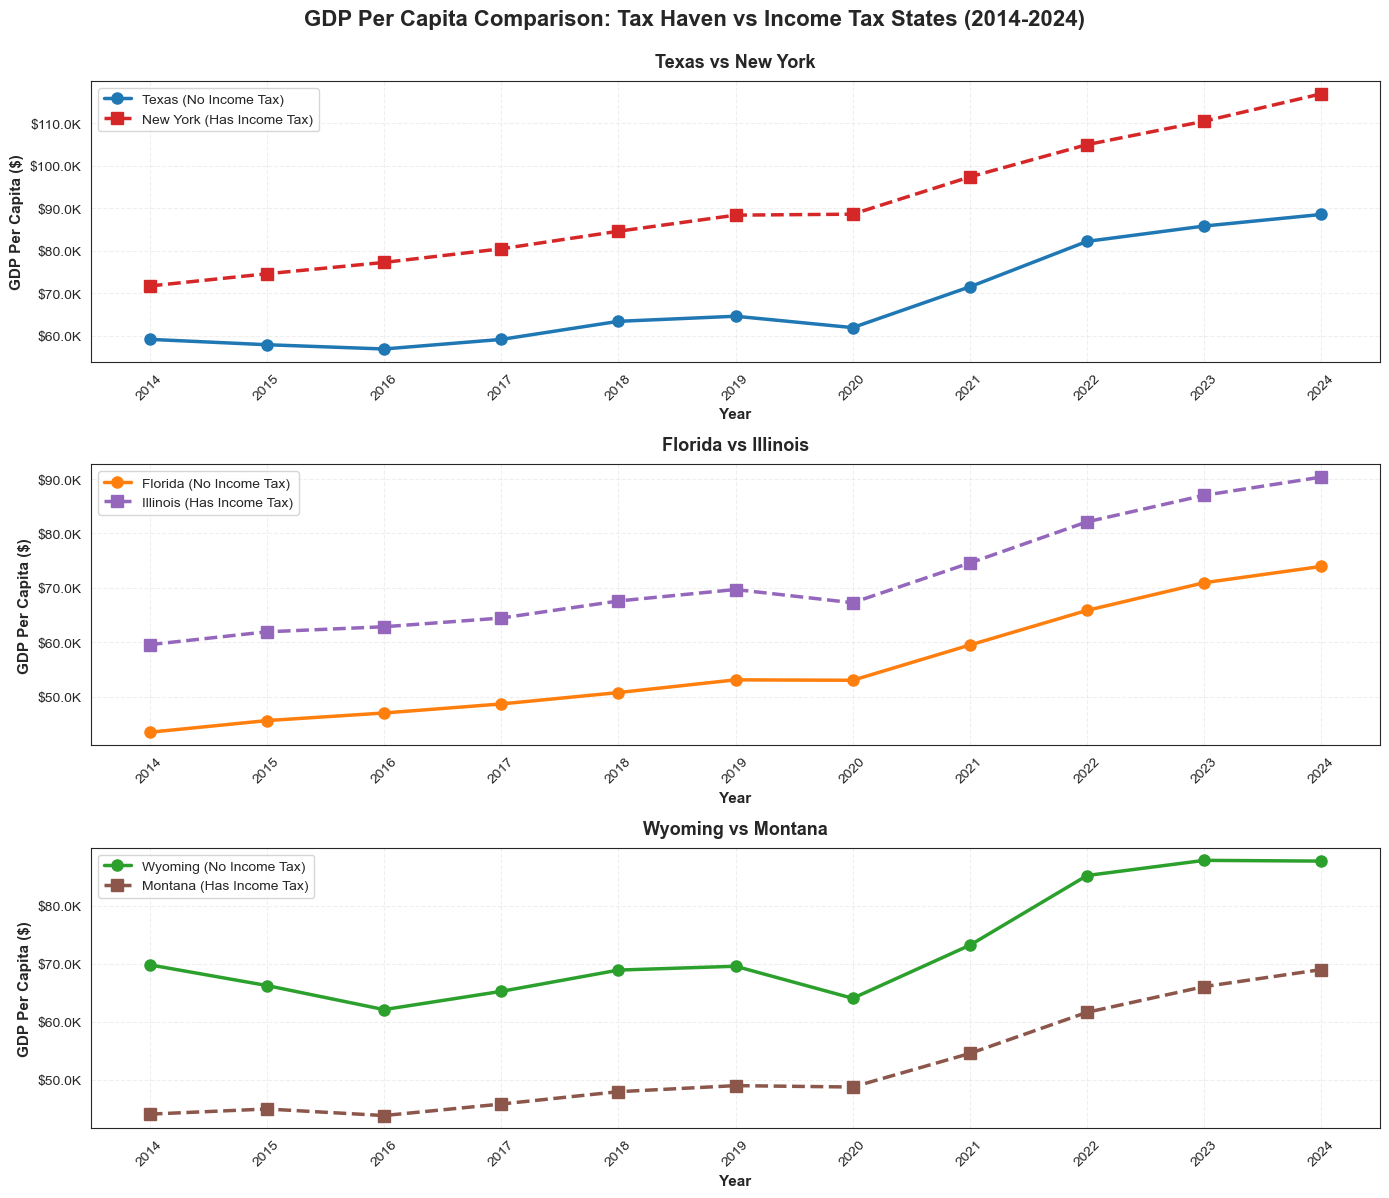

In [46]:
plot_single_metric(state_merge, state_pairs, 'GDP_Per_Capita', year_range=(2014, 2024), save_path=None)

State  Year  Unemployment_Rate
99   Florida  2014             6.4400
100  Florida  2015             5.5000
101  Florida  2016             4.9075
102  Florida  2017             4.2850
103  Florida  2018             3.6425
..       ...   ...                ...
567  Wyoming  2020             5.8575
568  Wyoming  2021             4.5500
569  Wyoming  2022             3.4325
570  Wyoming  2023             2.8825
571  Wyoming  2024             3.2150

[66 rows x 3 columns]

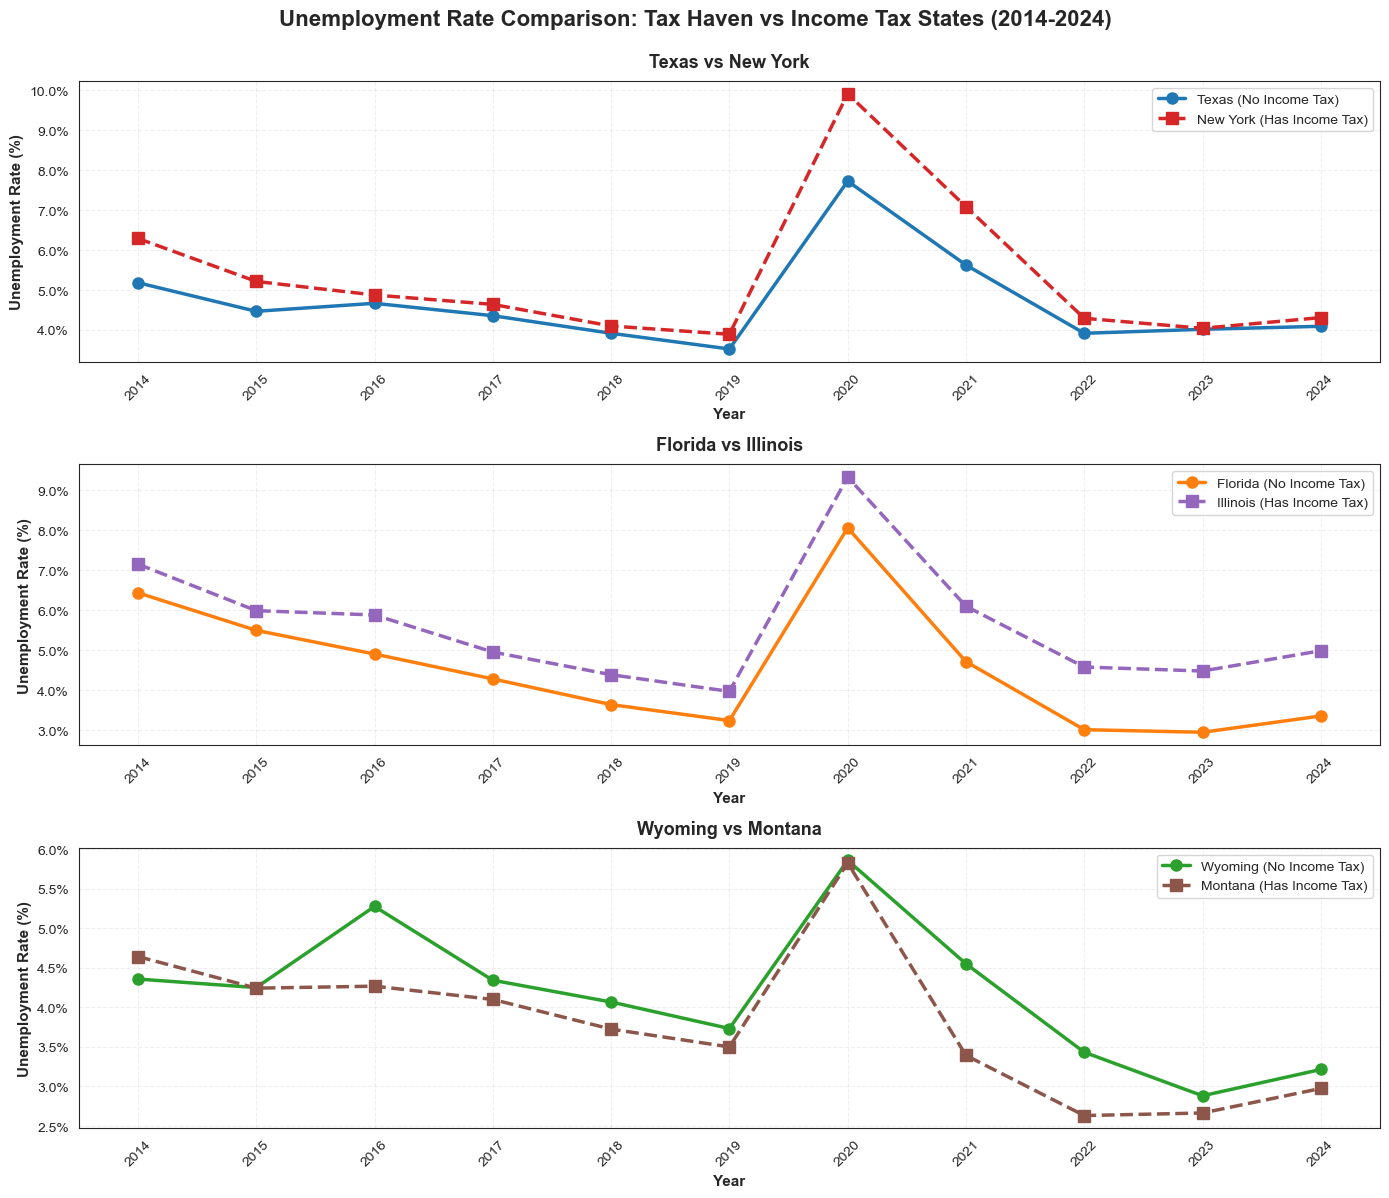

In [47]:
plot_single_metric(state_merge, state_pairs, 'Unemployment_Rate', year_range=(2014, 2024), save_path=None)

State  Year  Housing_Price_Index
99   Florida  2014             212.9175
100  Florida  2015             232.5350
101  Florida  2016             254.4875
102  Florida  2017             276.0950
103  Florida  2018             297.3675
..       ...   ...                  ...
567  Wyoming  2020             374.8925
568  Wyoming  2021             425.0500
569  Wyoming  2022             481.3725
570  Wyoming  2023             500.2500
571  Wyoming  2024             529.6025

[66 rows x 3 columns]

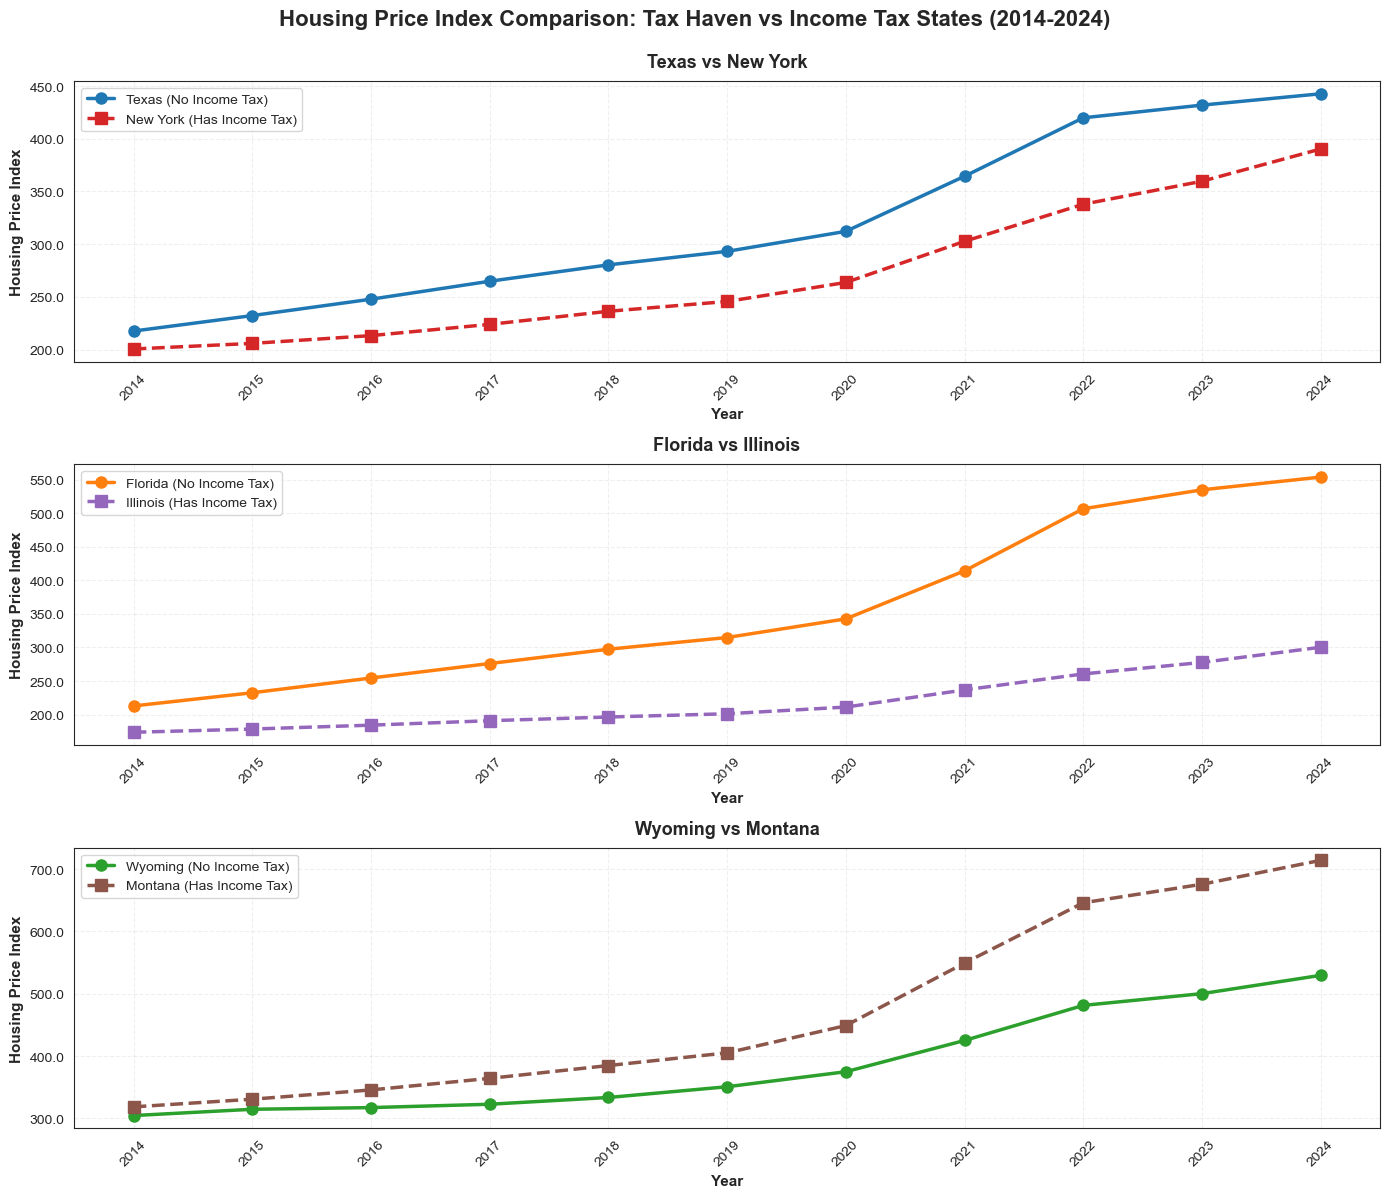

In [48]:
plot_single_metric(state_merge, state_pairs, 'Housing_Price_Index', year_range=(2014, 2024), save_path=None)

State  Year  Formations
99   Florida  2014    604750.0
100  Florida  2015    626700.0
101  Florida  2016    615275.0
102  Florida  2017    615625.0
103  Florida  2018    642250.0
..       ...   ...         ...
567  Wyoming  2020     28475.0
568  Wyoming  2021     31450.0
569  Wyoming  2022     40225.0
570  Wyoming  2023     53125.0
571  Wyoming  2024     58675.0

[66 rows x 3 columns]

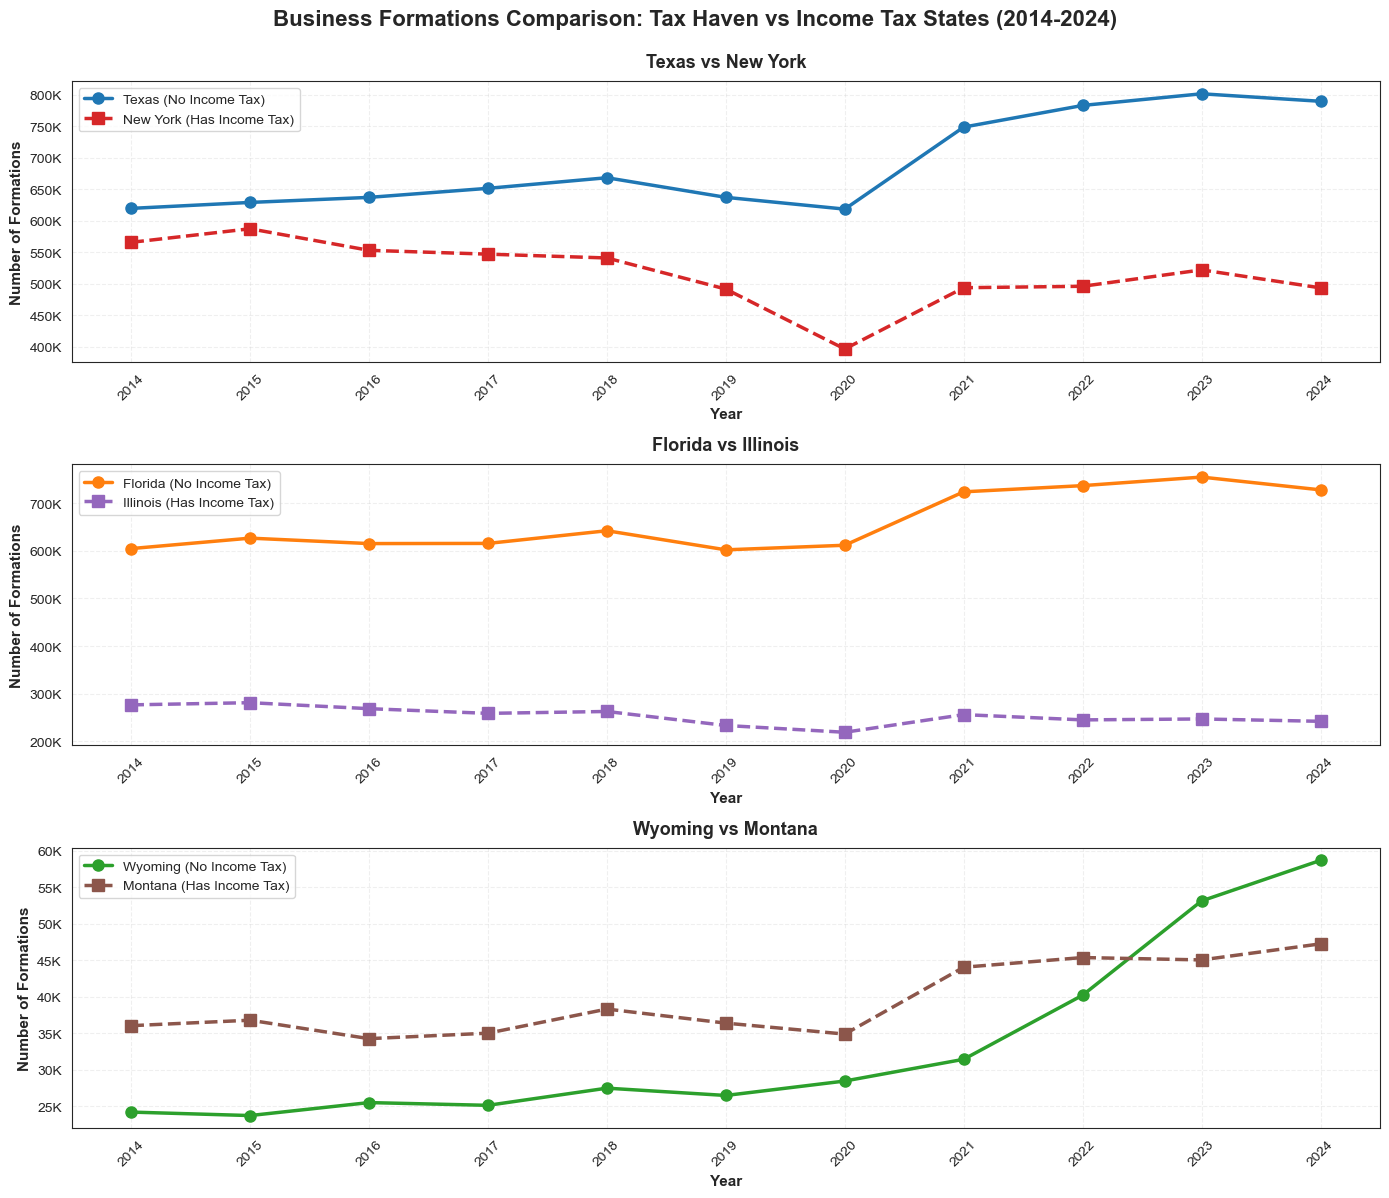

In [49]:
plot_single_metric(state_merge, state_pairs, 'Formations', year_range=(2014, 2024), save_path=None)

State  Year  Personal_Income
99   Florida  2014       848535.325
100  Florida  2015       905450.475
101  Florida  2016       938985.625
102  Florida  2017      1011002.175
103  Florida  2018      1078010.575
..       ...   ...              ...
567  Wyoming  2020        37602.900
568  Wyoming  2021        41420.450
569  Wyoming  2022        45259.275
570  Wyoming  2023        48583.000
571  Wyoming  2024        50815.400

[66 rows x 3 columns]

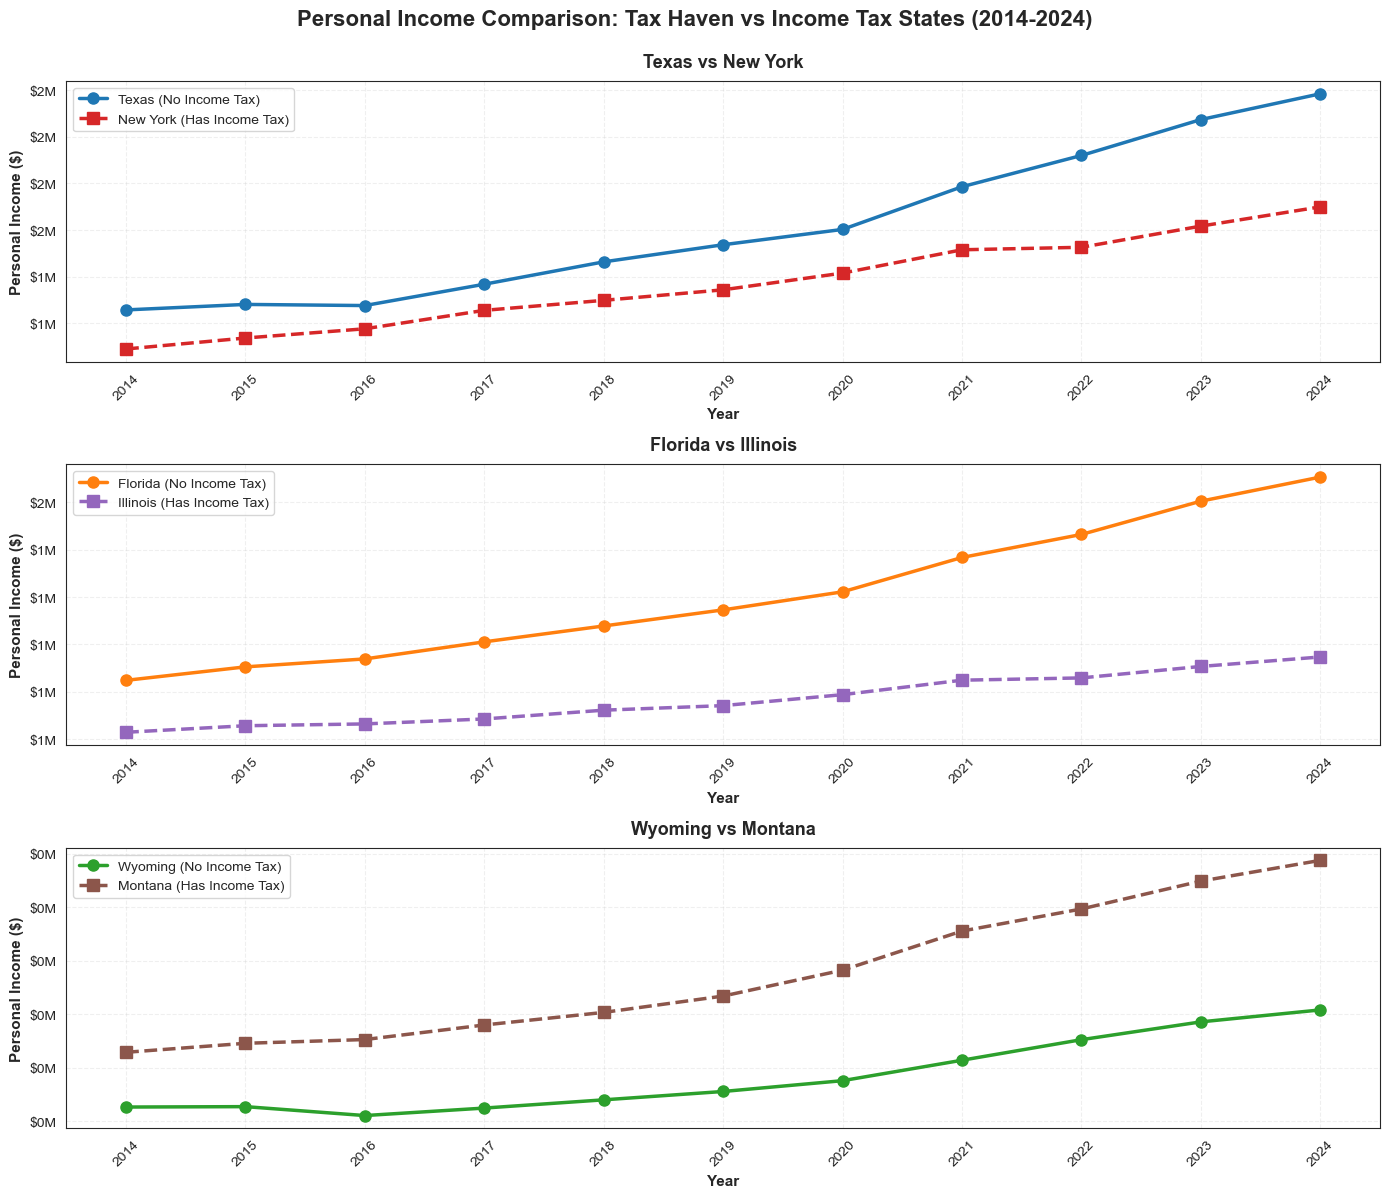

In [50]:
plot_single_metric(state_merge, state_pairs, 'Personal_Income', year_range=(2014, 2024), save_path=None)

State  Year  GDP_Per_Capita
99   Florida  2014    43432.766997
100  Florida  2015    45580.816574
101  Florida  2016    46978.412769
102  Florida  2017    48641.642323
103  Florida  2018    50736.668863
..       ...   ...             ...
567  Wyoming  2020    64027.056295
568  Wyoming  2021    73166.894178
569  Wyoming  2022    85165.435310
570  Wyoming  2023    87772.917180
571  Wyoming  2024    87645.796148

[66 rows x 3 columns]

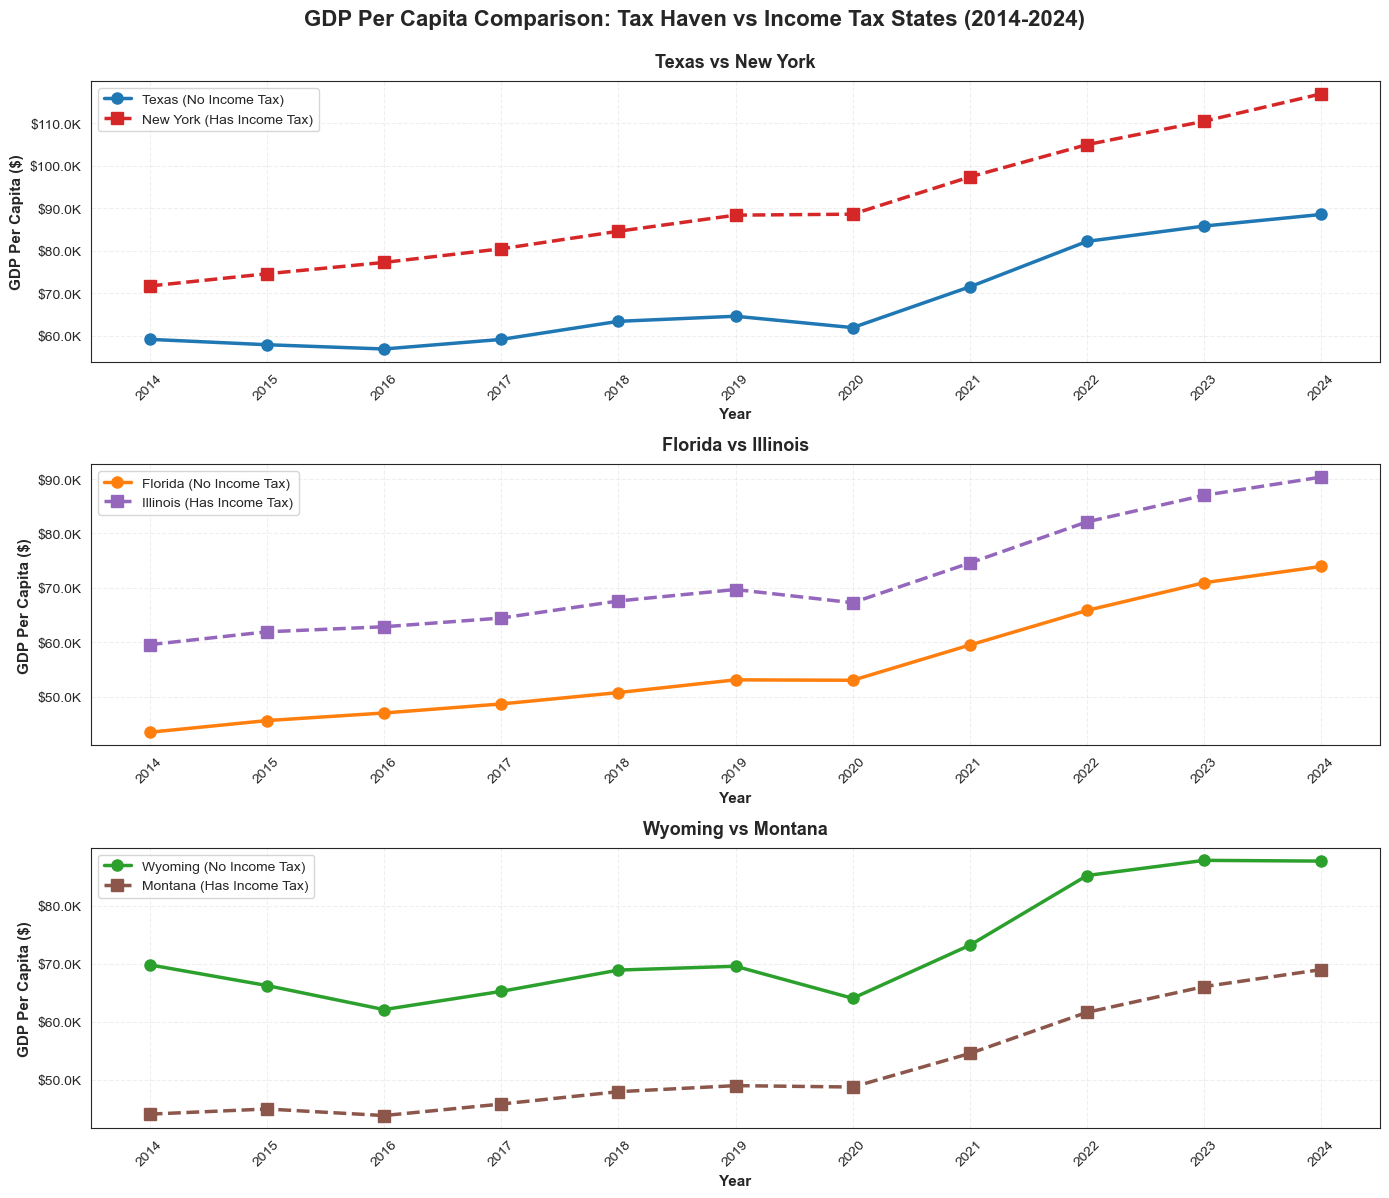

In [51]:
plot_single_metric(state_merge, state_pairs, 'GDP_Per_Capita', year_range=(2014, 2024), save_path=None)

State  Year  Unemployment_Rate
99   Florida  2014             6.4400
100  Florida  2015             5.5000
101  Florida  2016             4.9075
102  Florida  2017             4.2850
103  Florida  2018             3.6425
..       ...   ...                ...
567  Wyoming  2020             5.8575
568  Wyoming  2021             4.5500
569  Wyoming  2022             3.4325
570  Wyoming  2023             2.8825
571  Wyoming  2024             3.2150

[66 rows x 3 columns]

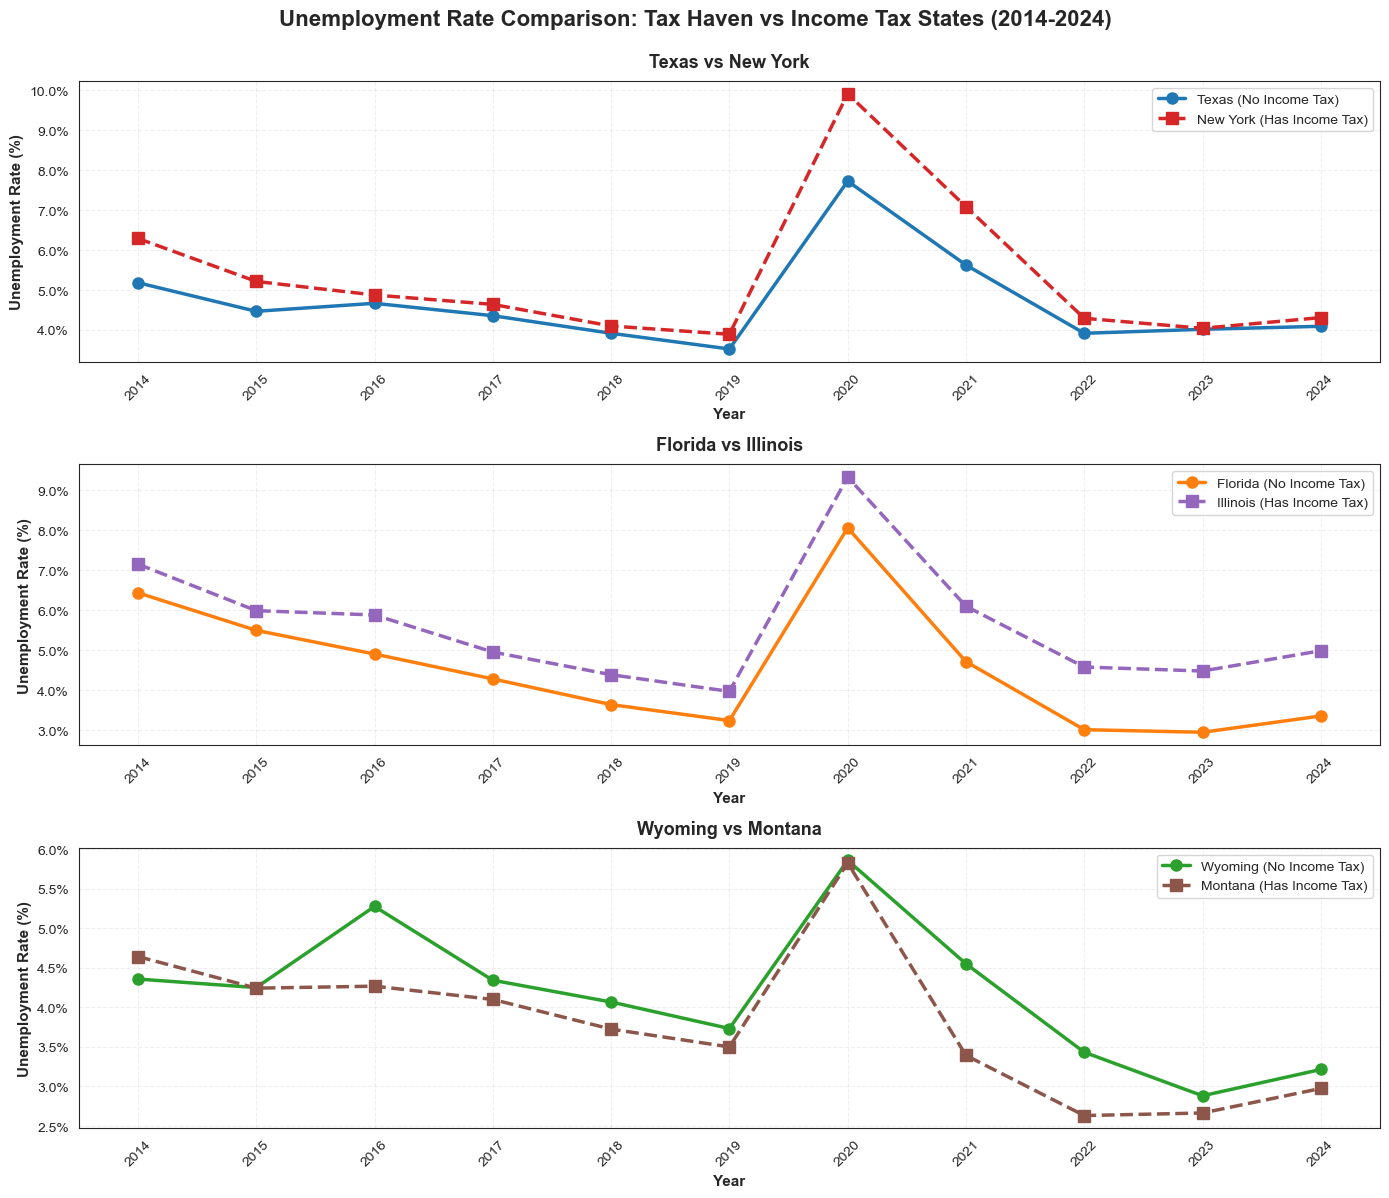

In [52]:
plot_single_metric(state_merge, state_pairs, 'Unemployment_Rate', year_range=(2014, 2024), save_path=None)

State  Year  Housing_Price_Index
99   Florida  2014             212.9175
100  Florida  2015             232.5350
101  Florida  2016             254.4875
102  Florida  2017             276.0950
103  Florida  2018             297.3675
..       ...   ...                  ...
567  Wyoming  2020             374.8925
568  Wyoming  2021             425.0500
569  Wyoming  2022             481.3725
570  Wyoming  2023             500.2500
571  Wyoming  2024             529.6025

[66 rows x 3 columns]

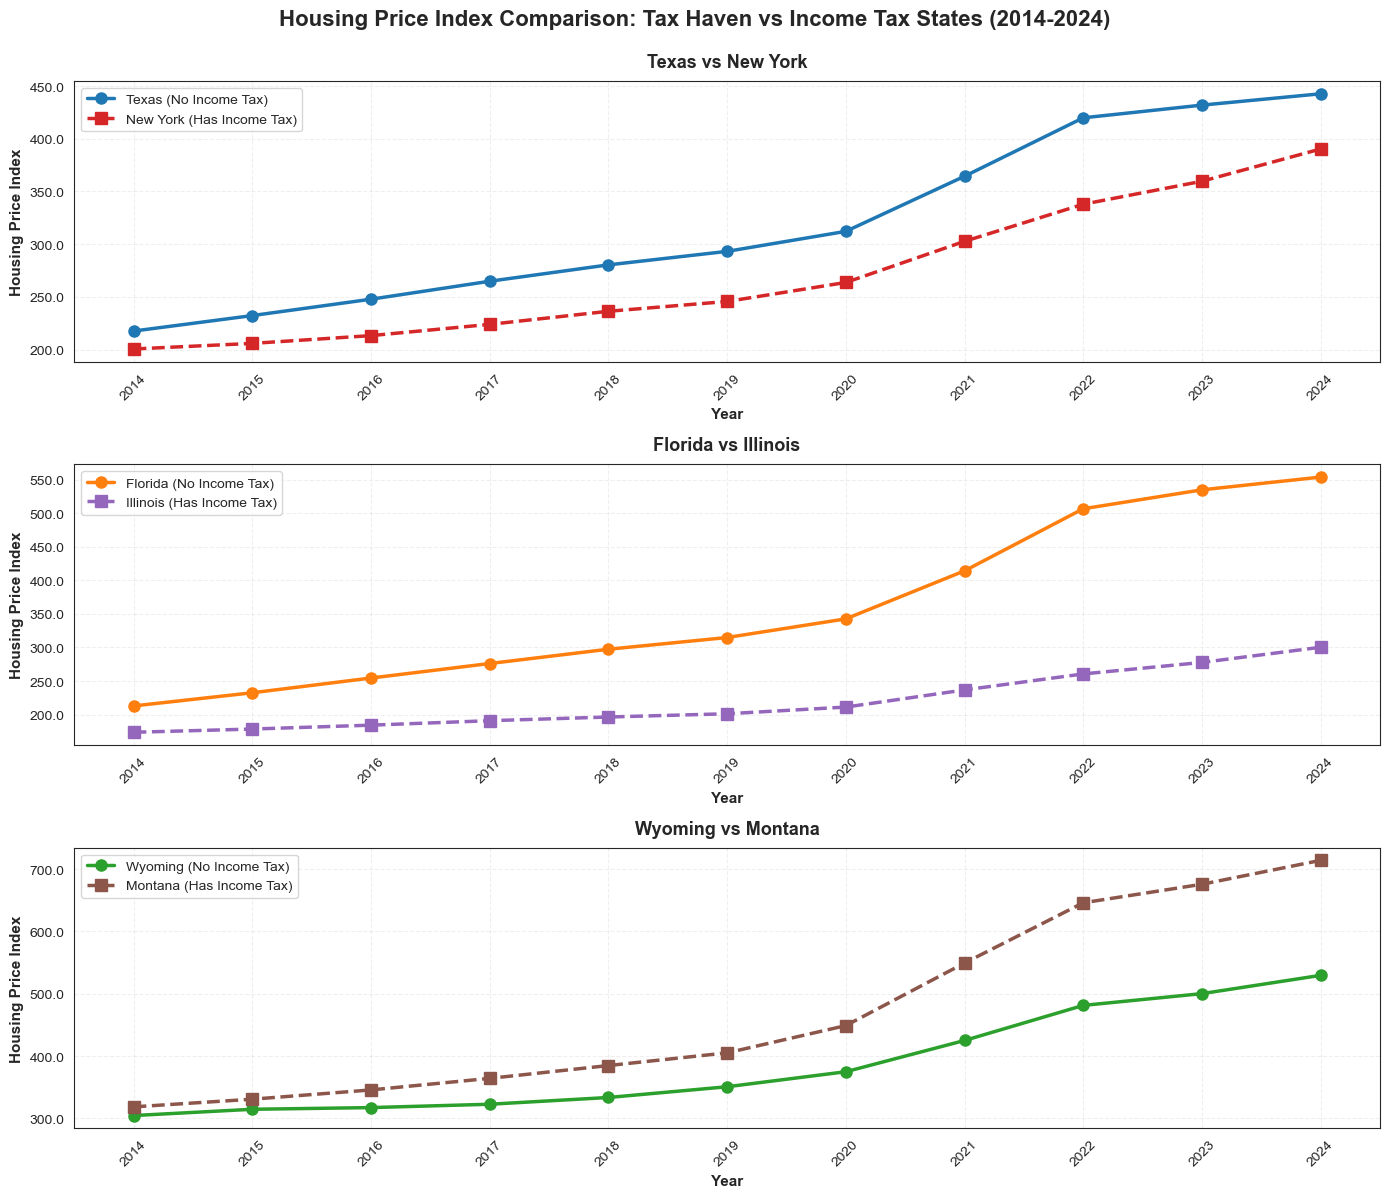

In [53]:
plot_single_metric(state_merge, state_pairs, 'Housing_Price_Index', year_range=(2014, 2024), save_path=None)

State  Year  Formations
99   Florida  2014    604750.0
100  Florida  2015    626700.0
101  Florida  2016    615275.0
102  Florida  2017    615625.0
103  Florida  2018    642250.0
..       ...   ...         ...
567  Wyoming  2020     28475.0
568  Wyoming  2021     31450.0
569  Wyoming  2022     40225.0
570  Wyoming  2023     53125.0
571  Wyoming  2024     58675.0

[66 rows x 3 columns]

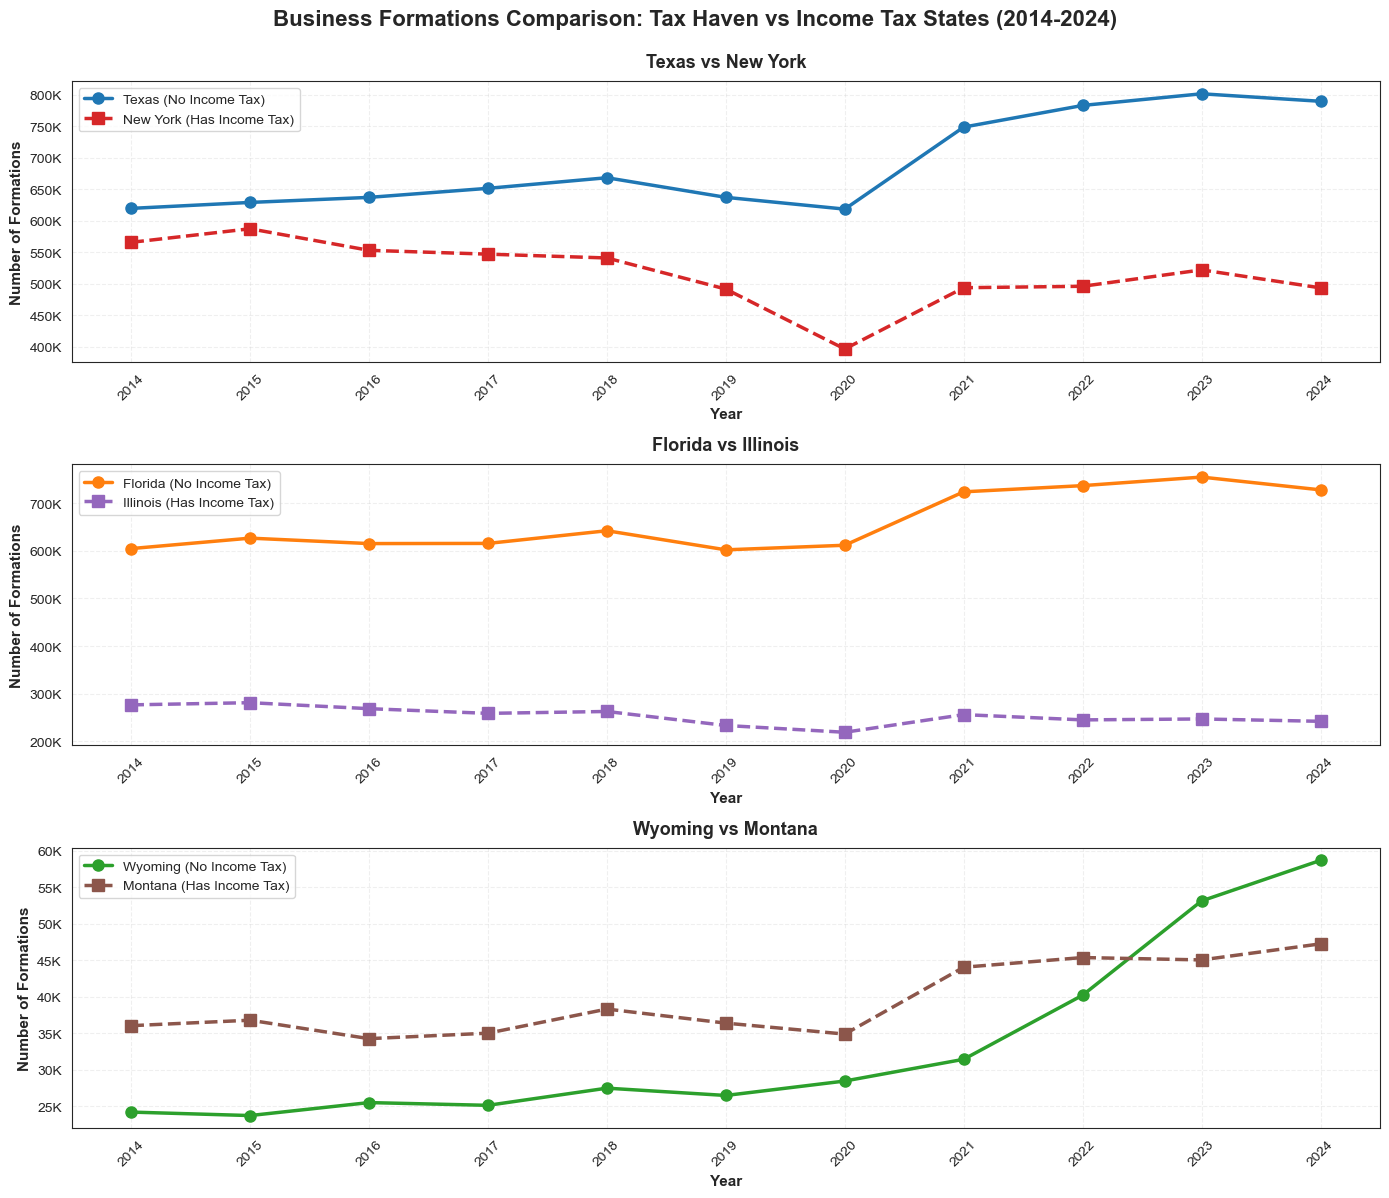

In [54]:
plot_single_metric(state_merge, state_pairs, 'Formations', year_range=(2014, 2024), save_path=None)

State  Year   Population
99   Florida  2014  19803311.75
100  Florida  2015  20150238.50
101  Florida  2016  20530724.50
102  Florida  2017  20864156.75
103  Florida  2018  21130389.50
..       ...   ...          ...
567  Wyoming  2020    577610.50
568  Wyoming  2021    579641.25
569  Wyoming  2022    582047.75
570  Wyoming  2023    585033.25
571  Wyoming  2024    587571.25

[66 rows x 3 columns]

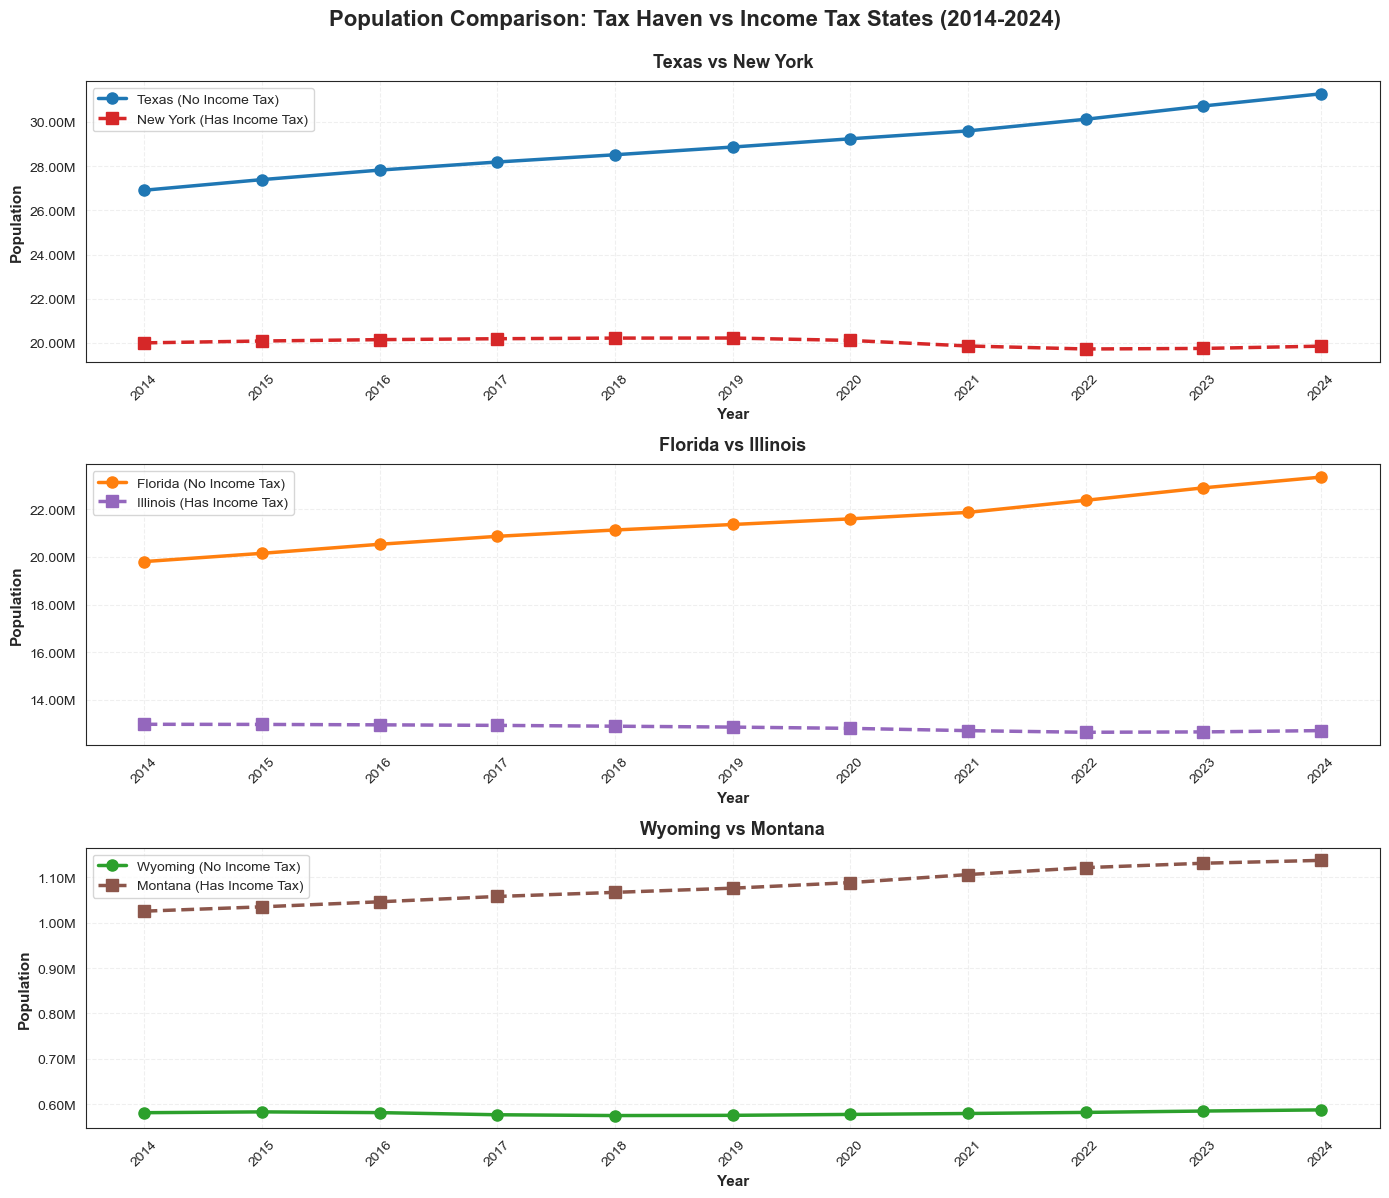

In [55]:
plot_single_metric(state_merge, state_pairs, 'Population', year_range=(2014, 2024), save_path=None)

In [56]:
def plot_average_comparison(df, state_pairs, metric_name, year_range=(2014, 2024), save_path=None):
    """
    Create a single plot comparing the AVERAGE of tax haven states vs AVERAGE of non-tax haven states

    Parameters:
    -----------
    df : DataFrame
        The main dataframe
    state_pairs : dict
        Dictionary mapping tax haven states to comparison states
    metric_name : str
        Name of the metric to plot (must be in METRICS dictionary)
    year_range : tuple
        (start_year, end_year)
    save_path : str, optional
        Path to save the figure. If None, uses default naming

    Returns:
    --------
    DataFrame with the averaged metric data
    """
    if metric_name not in METRICS:
        raise ValueError(f"Metric '{metric_name}' not found. Available: {list(METRICS.keys())}")

    metric_config = METRICS[metric_name]

    # Get tax haven and non-tax haven states
    tax_haven_states = list(state_pairs.keys())
    non_tax_haven_states = list(state_pairs.values())

    # Calculate metric for all states
    all_states = tax_haven_states + non_tax_haven_states
    metric_data = calculate_metric_by_year(df, all_states, metric_name, year_range)

    # Calculate averages for each group by year
    haven_avg = metric_data[metric_data['State'].isin(tax_haven_states)].groupby('Year')[metric_name].mean().reset_index()
    haven_avg.columns = ['Year', 'Average']
    haven_avg['Group'] = 'Tax Haven States (Avg)'

    non_haven_avg = metric_data[metric_data['State'].isin(non_tax_haven_states)].groupby('Year')[metric_name].mean().reset_index()
    non_haven_avg.columns = ['Year', 'Average']
    non_haven_avg['Group'] = 'Income Tax States (Avg)'

    # Combine for return
    combined_data = pd.concat([haven_avg, non_haven_avg], ignore_index=True)

    # Create single plot
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))

    # Plot lines
    ax.plot(haven_avg['Year'], haven_avg['Average'],
            marker='o', linewidth=3, markersize=10,
            label=f'Tax Haven States Average\n({", ".join(tax_haven_states)})',
            color='#1f77b4', alpha=0.8)

    ax.plot(non_haven_avg['Year'], non_haven_avg['Average'],
            marker='s', linewidth=3, markersize=10,
            label=f'Income Tax States Average\n({", ".join(non_tax_haven_states)})',
            color='#d62728', linestyle='--', alpha=0.8)

    # Formatting
    ax.set_xlabel('Year', fontsize=13, fontweight='bold')
    ax.set_ylabel(metric_config['ylabel'], fontsize=13, fontweight='bold')
    ax.set_title(f'{metric_config["title"]} Comparison: Average of Tax Haven vs Income Tax States ({year_range[0]}-{year_range[1]})',
                 fontsize=15, fontweight='bold', pad=20)
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.ticklabel_format(style='plain', axis='y')

    # Format y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(metric_config['format']))

    # Set x-axis to show all years
    ax.set_xticks(range(year_range[0], year_range[1] + 1))
    ax.set_xticklabels(range(year_range[0], year_range[1] + 1), rotation=45)

    plt.tight_layout()

    return combined_data

Year       Average                    Group
0   2014  3.195627e+07   Tax Haven States (Avg)
1   2015  3.175759e+07   Tax Haven States (Avg)
2   2016  3.143202e+07   Tax Haven States (Avg)
3   2017  3.337734e+07   Tax Haven States (Avg)
4   2018  3.585051e+07   Tax Haven States (Avg)
5   2019  3.759178e+07   Tax Haven States (Avg)
6   2020  3.511759e+07   Tax Haven States (Avg)
7   2021  4.275946e+07   Tax Haven States (Avg)
8   2022  4.989358e+07   Tax Haven States (Avg)
9   2023  5.086781e+07   Tax Haven States (Avg)
10  2024  5.121568e+07   Tax Haven States (Avg)
11  2014  4.015702e+07  Income Tax States (Avg)
12  2015  4.143651e+07  Income Tax States (Avg)
13  2016  4.066401e+07  Income Tax States (Avg)
14  2017  4.116676e+07  Income Tax States (Avg)
15  2018  4.357807e+07  Income Tax States (Avg)
16  2019  4.653631e+07  Income Tax States (Avg)
17  2020  4.686555e+07  Income Tax States (Avg)
18  2021  5.923348e+07  Income Tax States (Avg)
19  2022  6.673687e+07  Income Tax States (Avg)
20  2023  6.345875e+07  Income Tax States (Avg)
21  2024  6.597790e+07  Income Tax States (Avg)

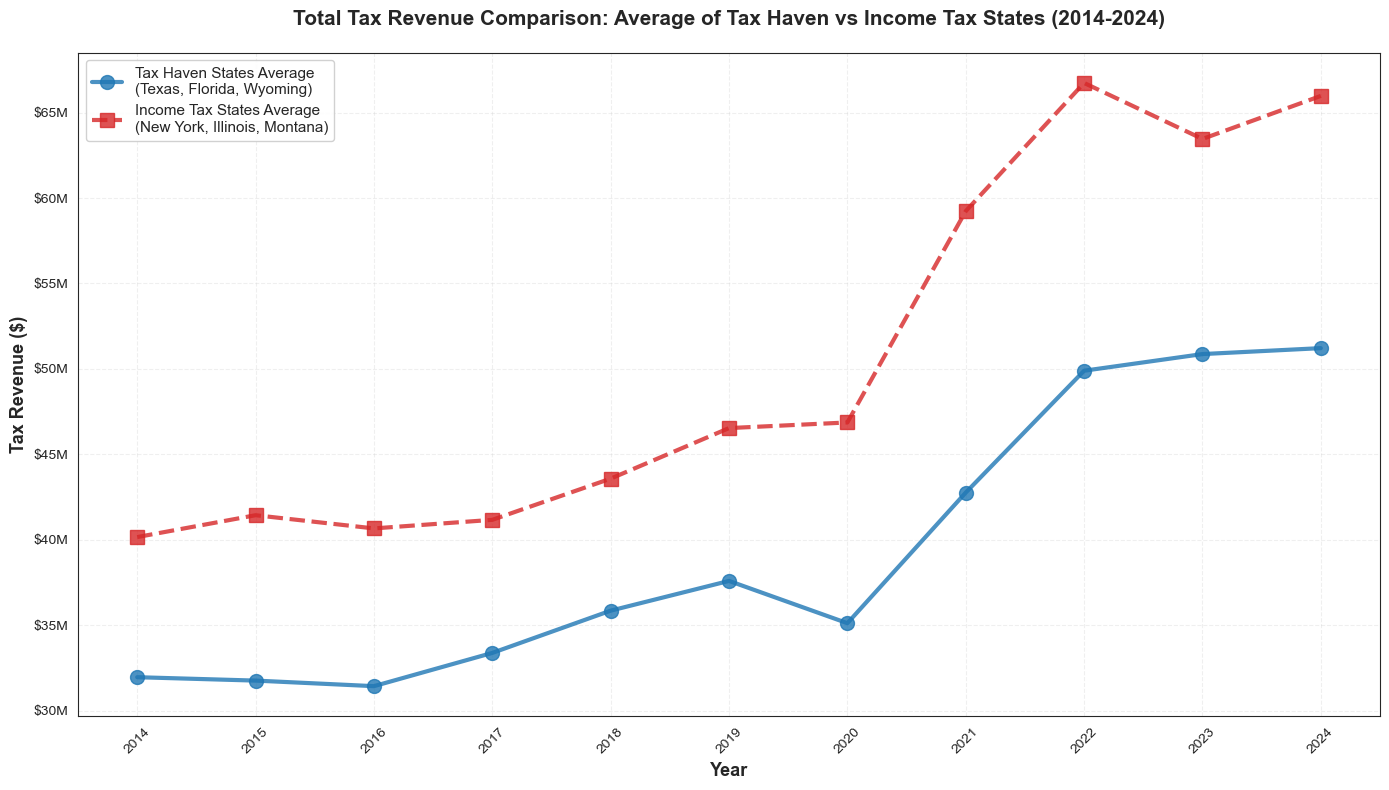

In [57]:
plot_average_comparison(state_merge, state_pairs, 'Total_Tax_Revenue', year_range=(2014, 2024), save_path=None)

Year       Average                    Group
0   2014  8.309547e+07   Tax Haven States (Avg)
1   2015  8.476917e+07   Tax Haven States (Avg)
2   2016  8.611961e+07   Tax Haven States (Avg)
3   2017  9.066001e+07   Tax Haven States (Avg)
4   2018  9.732423e+07   Tax Haven States (Avg)
5   2019  1.012873e+08   Tax Haven States (Avg)
6   2020  9.974354e+07   Tax Haven States (Avg)
7   2021  1.153411e+08   Tax Haven States (Avg)
8   2022  1.333387e+08   Tax Haven States (Avg)
9   2023  1.437743e+08   Tax Haven States (Avg)
10  2024  1.515991e+08   Tax Haven States (Avg)
11  2014  7.507006e+07  Income Tax States (Avg)
12  2015  7.825364e+07  Income Tax States (Avg)
13  2016  8.054170e+07  Income Tax States (Avg)
14  2017  8.353660e+07  Income Tax States (Avg)
15  2018  8.776140e+07  Income Tax States (Avg)
16  2019  9.119294e+07  Income Tax States (Avg)
17  2020  8.987892e+07  Income Tax States (Avg)
18  2021  9.806875e+07  Income Tax States (Avg)
19  2022  1.059300e+08  Income Tax States (Avg)
20  2023  1.119344e+08  Income Tax States (Avg)
21  2024  1.182895e+08  Income Tax States (Avg)

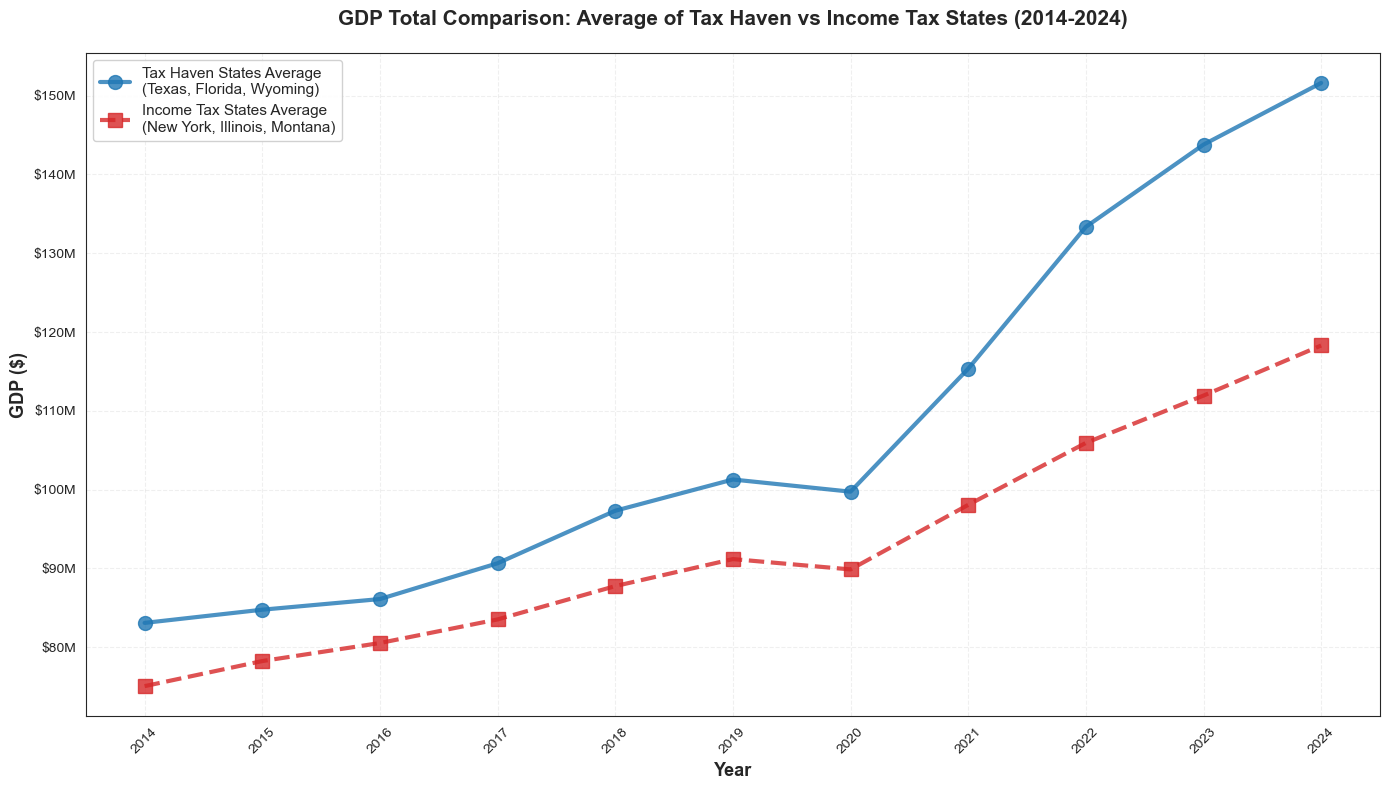

In [58]:
plot_average_comparison(state_merge, state_pairs, 'GDP_Total', year_range=(2014, 2024), save_path=None)

Year       Average                    Group
0   2014  57461.611385   Tax Haven States (Avg)
1   2015  56570.388591   Tax Haven States (Avg)
2   2016  55319.917618   Tax Haven States (Avg)
3   2017  57669.378380   Tax Haven States (Avg)
4   2018  61008.172899   Tax Haven States (Avg)
5   2019  62408.113400   Tax Haven States (Avg)
6   2020  59651.280311   Tax Haven States (Avg)
7   2021  68059.259889   Tax Haven States (Avg)
8   2022  77749.515335   Tax Haven States (Avg)
9   2023  81517.232933   Tax Haven States (Avg)
10  2024  83383.436488   Tax Haven States (Avg)
11  2014  58450.831424  Income Tax States (Avg)
12  2015  60493.724861  Income Tax States (Avg)
13  2016  61316.062408  Income Tax States (Avg)
14  2017  63580.984850  Income Tax States (Avg)
15  2018  66712.698457  Income Tax States (Avg)
16  2019  69026.109013  Income Tax States (Avg)
17  2020  68213.099891  Income Tax States (Avg)
18  2021  75502.535230  Income Tax States (Avg)
19  2022  82915.889460  Income Tax States (Avg)
20  2023  87857.092267  Income Tax States (Avg)
21  2024  92101.490197  Income Tax States (Avg)

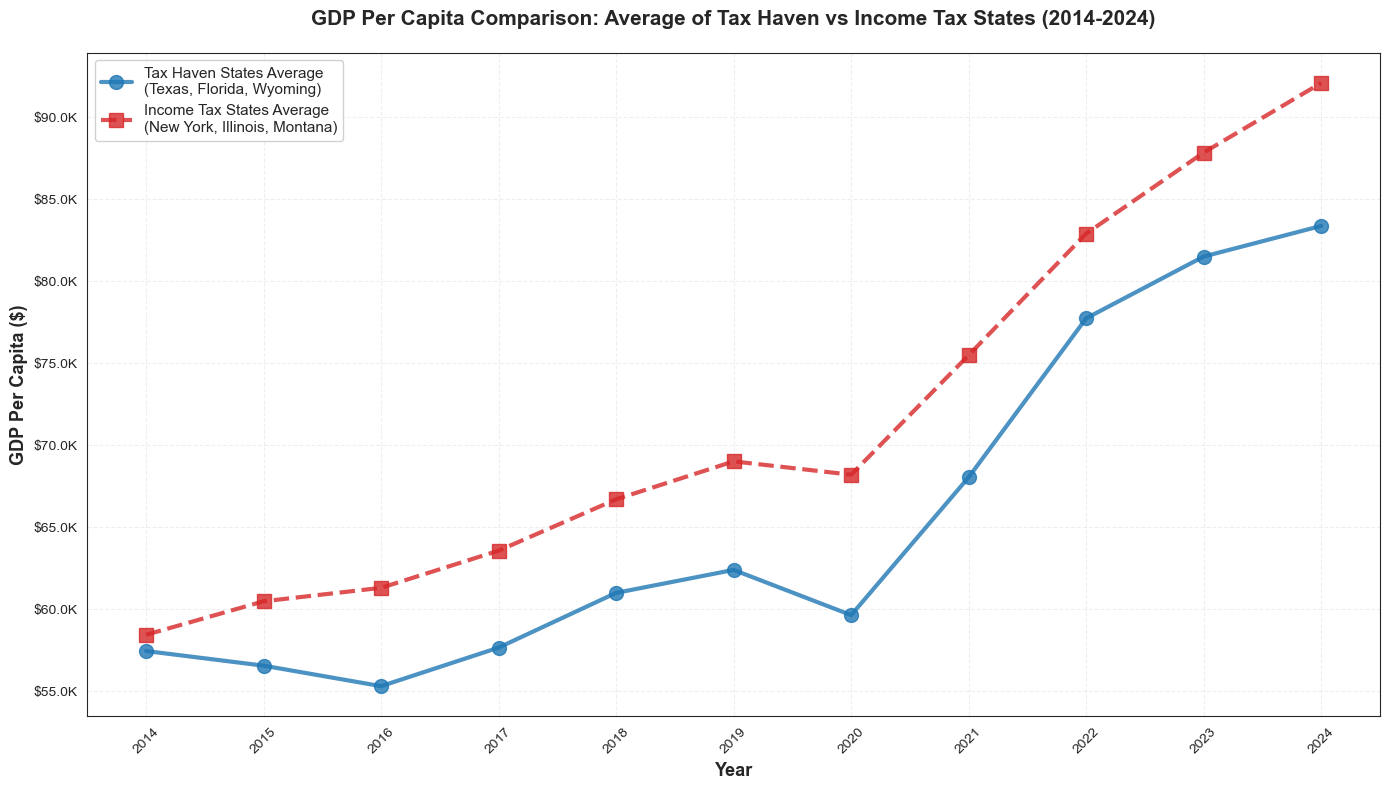

In [59]:
plot_average_comparison(state_merge, state_pairs, 'GDP_Per_Capita', year_range=(2014, 2024), save_path=None)

Year   Average                    Group
0   2014  5.326667   Tax Haven States (Avg)
1   2015  4.739167   Tax Haven States (Avg)
2   2016  4.950000   Tax Haven States (Avg)
3   2017  4.328333   Tax Haven States (Avg)
4   2018  3.875833   Tax Haven States (Avg)
5   2019  3.500000   Tax Haven States (Avg)
6   2020  7.215000   Tax Haven States (Avg)
7   2021  4.964167   Tax Haven States (Avg)
8   2022  3.455000   Tax Haven States (Avg)
9   2023  3.283333   Tax Haven States (Avg)
10  2024  3.555000   Tax Haven States (Avg)
11  2014  6.030000  Income Tax States (Avg)
12  2015  5.150000  Income Tax States (Avg)
13  2016  5.009167  Income Tax States (Avg)
14  2017  4.565833  Income Tax States (Avg)
15  2018  4.071667  Income Tax States (Avg)
16  2019  3.788333  Income Tax States (Avg)
17  2020  8.355833  Income Tax States (Avg)
18  2021  5.525833  Income Tax States (Avg)
19  2022  3.835833  Income Tax States (Avg)
20  2023  3.730000  Income Tax States (Avg)
21  2024  4.091667  Income Tax States (Avg)

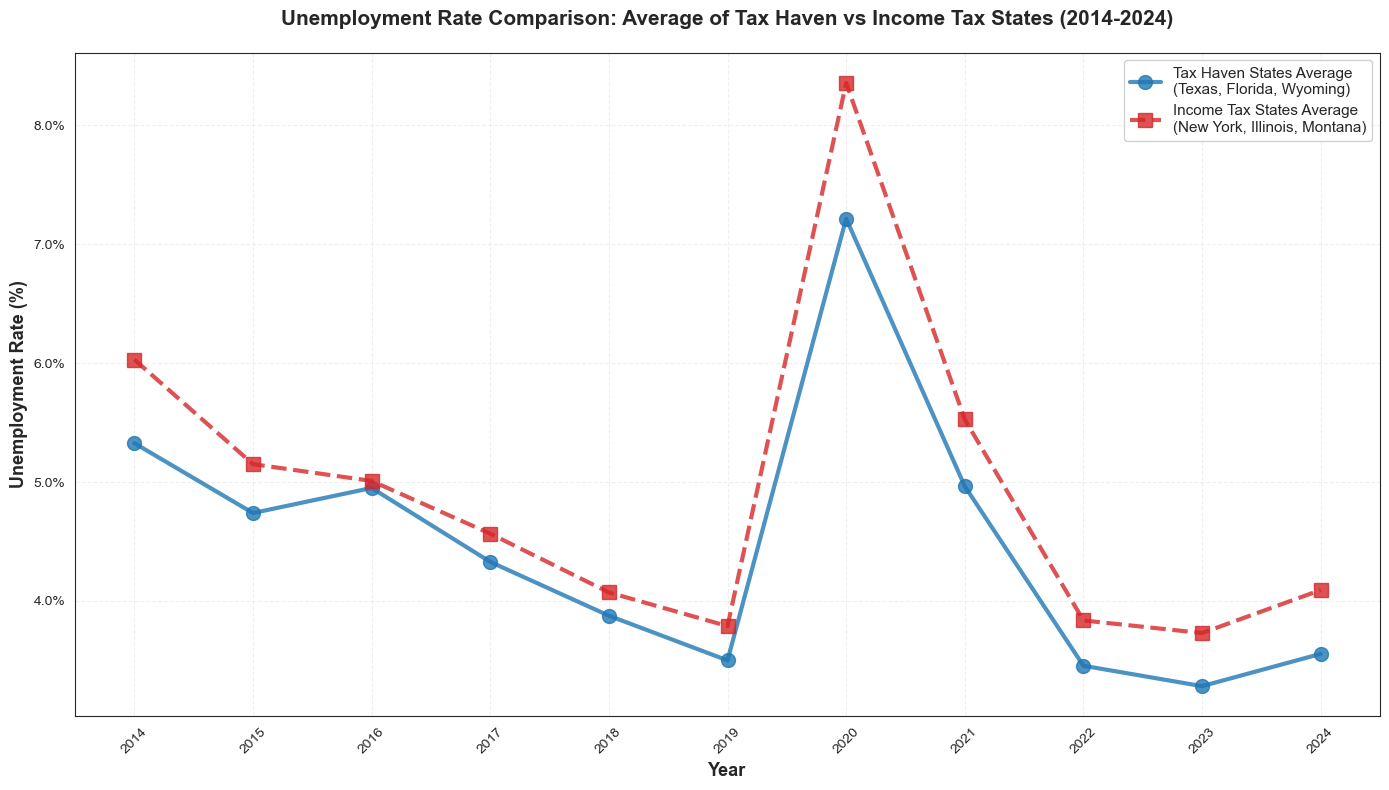

In [60]:
plot_average_comparison(state_merge, state_pairs, 'Unemployment_Rate', year_range=(2014, 2024), save_path=None)

Year       Average                    Group
0   2014  7.129515e+05   Tax Haven States (Avg)
1   2015  7.397921e+05   Tax Haven States (Avg)
2   2016  7.488021e+05   Tax Haven States (Avg)
3   2017  8.037719e+05   Tax Haven States (Avg)
4   2018  8.586085e+05   Tax Haven States (Avg)
5   2019  9.062433e+05   Tax Haven States (Avg)
6   2020  9.542063e+05   Tax Haven States (Avg)
7   2021  1.064848e+06   Tax Haven States (Avg)
8   2022  1.143255e+06   Tax Haven States (Avg)
9   2023  1.242486e+06   Tax Haven States (Avg)
10  2024  1.313985e+06   Tax Haven States (Avg)
11  2014  5.874557e+05  Income Tax States (Avg)
12  2015  6.129153e+05  Income Tax States (Avg)
13  2016  6.288749e+05  Income Tax States (Avg)
14  2017  6.631376e+05  Income Tax States (Avg)
15  2018  6.905692e+05  Income Tax States (Avg)
16  2019  7.130527e+05  Income Tax States (Avg)
17  2020  7.540132e+05  Income Tax States (Avg)
18  2021  8.101340e+05  Income Tax States (Avg)
19  2022  8.182638e+05  Income Tax States (Avg)
20  2023  8.664090e+05  Income Tax States (Avg)
21  2024  9.085348e+05  Income Tax States (Avg)

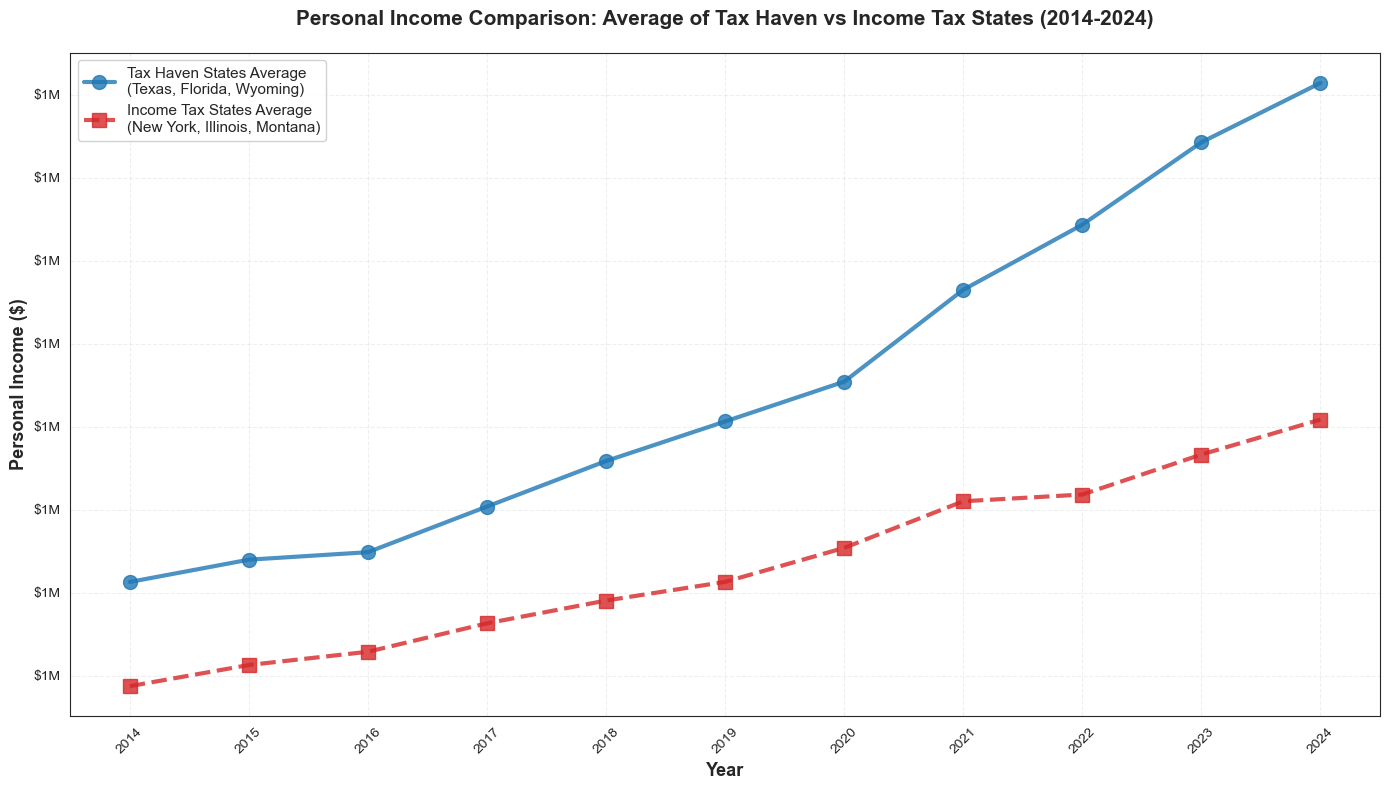

In [61]:
plot_average_comparison(state_merge, state_pairs, 'Personal_Income', year_range=(2014, 2024), save_path=None)

Year     Average                    Group
0   2014  244.999167   Tax Haven States (Avg)
1   2015  259.795833   Tax Haven States (Avg)
2   2016  273.187500   Tax Haven States (Avg)
3   2017  287.866667   Tax Haven States (Avg)
4   2018  303.748333   Tax Haven States (Avg)
5   2019  319.585000   Tax Haven States (Avg)
6   2020  343.188333   Tax Haven States (Avg)
7   2021  401.169167   Tax Haven States (Avg)
8   2022  469.229167   Tax Haven States (Avg)
9   2023  488.945833   Tax Haven States (Avg)
10  2024  508.640000   Tax Haven States (Avg)
11  2014  230.923333  Income Tax States (Avg)
12  2015  238.390000  Income Tax States (Avg)
13  2016  247.738333  Income Tax States (Avg)
14  2017  259.696667  Income Tax States (Avg)
15  2018  272.519167  Income Tax States (Avg)
16  2019  284.029167  Income Tax States (Avg)
17  2020  307.941667  Income Tax States (Avg)
18  2021  362.912500  Income Tax States (Avg)
19  2022  414.839167  Income Tax States (Avg)
20  2023  437.722500  Income Tax States (Avg)
21  2024  468.240000  Income Tax States (Avg)

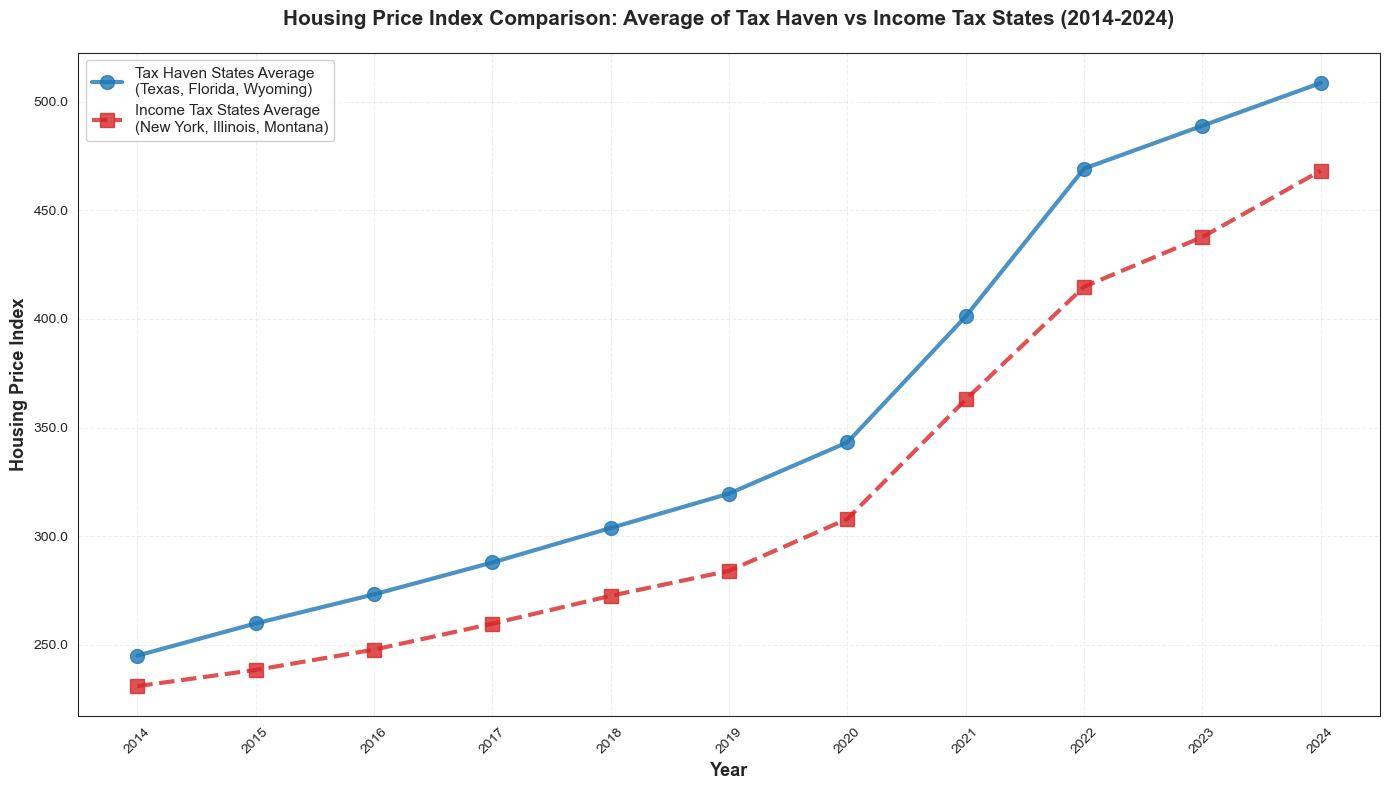

In [62]:
plot_average_comparison(state_merge, state_pairs, 'Housing_Price_Index', year_range=(2014, 2024), save_path=None)

Year        Average                    Group
0   2014  416250.000000   Tax Haven States (Avg)
1   2015  426558.333333   Tax Haven States (Avg)
2   2016  426008.333333   Tax Haven States (Avg)
3   2017  430791.666667   Tax Haven States (Avg)
4   2018  446050.000000   Tax Haven States (Avg)
5   2019  421983.333333   Tax Haven States (Avg)
6   2020  419616.666667   Tax Haven States (Avg)
7   2021  501366.666667   Tax Haven States (Avg)
8   2022  520075.000000   Tax Haven States (Avg)
9   2023  536525.000000   Tax Haven States (Avg)
10  2024  525458.333333   Tax Haven States (Avg)
11  2014  292850.000000  Income Tax States (Avg)
12  2015  301816.666667  Income Tax States (Avg)
13  2016  285383.333333  Income Tax States (Avg)
14  2017  280325.000000  Income Tax States (Avg)
15  2018  280733.333333  Income Tax States (Avg)
16  2019  253833.333333  Income Tax States (Avg)
17  2020  216916.666667  Income Tax States (Avg)
18  2021  264700.000000  Income Tax States (Avg)
19  2022  262225.000000  Income Tax States (Avg)
20  2023  271433.333333  Income Tax States (Avg)
21  2024  261008.333333  Income Tax States (Avg)

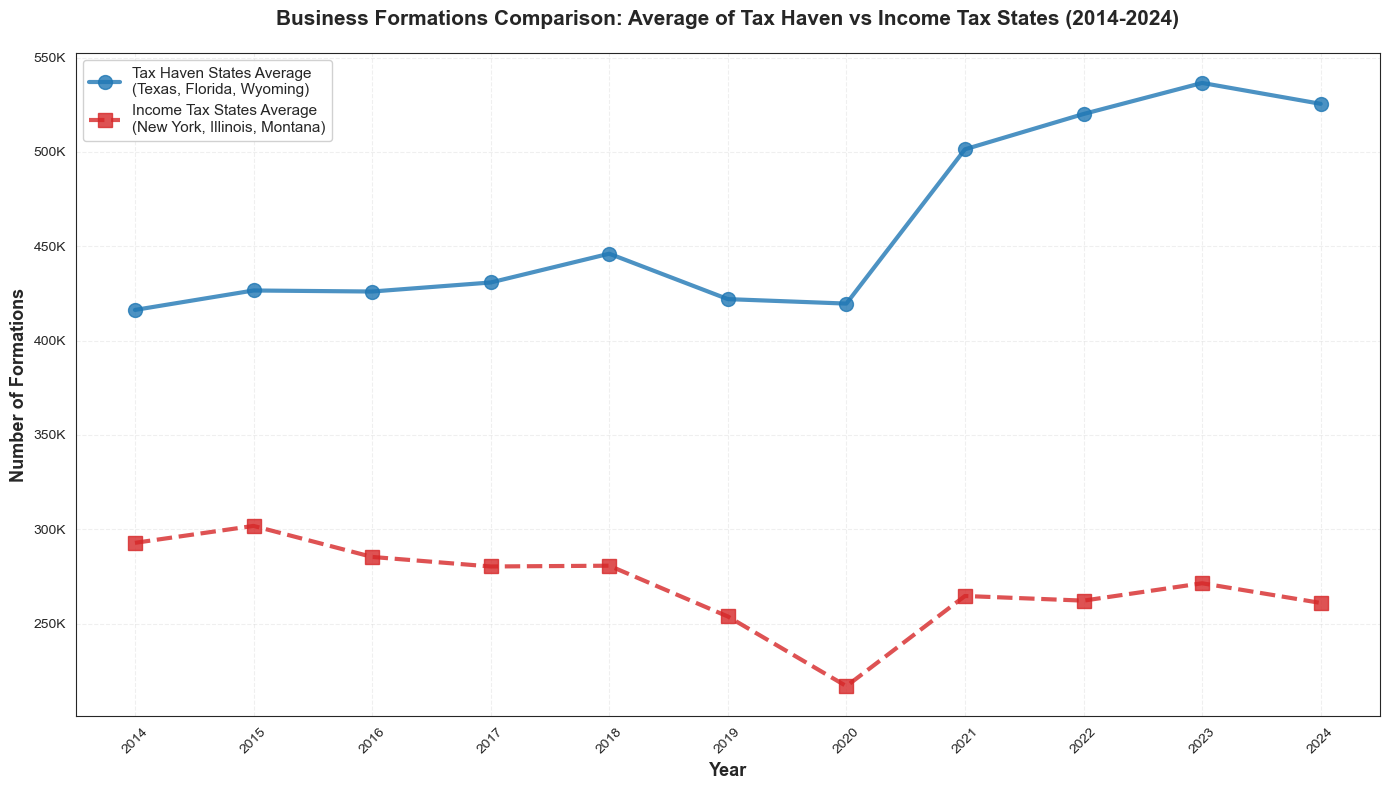

In [63]:
plot_average_comparison(state_merge, state_pairs, 'Formations', year_range=(2014, 2024), save_path=None)

Year       Average                    Group
0   2014  1.576528e+07   Tax Haven States (Avg)
1   2015  1.604165e+07   Tax Haven States (Avg)
2   2016  1.631135e+07   Tax Haven States (Avg)
3   2017  1.654303e+07   Tax Haven States (Avg)
4   2018  1.674044e+07   Tax Haven States (Avg)
5   2019  1.693407e+07   Tax Haven States (Avg)
6   2020  1.713788e+07   Tax Haven States (Avg)
7   2021  1.734836e+07   Tax Haven States (Avg)
8   2022  1.769407e+07   Tax Haven States (Avg)
9   2023  1.806998e+07   Tax Haven States (Avg)
10  2024  1.840483e+07   Tax Haven States (Avg)
11  2014  1.133252e+07  Income Tax States (Avg)
12  2015  1.136195e+07  Income Tax States (Avg)
13  2016  1.138041e+07  Income Tax States (Avg)
14  2017  1.139038e+07  Income Tax States (Avg)
15  2018  1.139142e+07  Income Tax States (Avg)
16  2019  1.138274e+07  Income Tax States (Avg)
17  2020  1.133308e+07  Income Tax States (Avg)
18  2021  1.122320e+07  Income Tax States (Avg)
19  2022  1.116037e+07  Income Tax States (Avg)
20  2023  1.117698e+07  Income Tax States (Avg)
21  2024  1.123192e+07  Income Tax States (Avg)

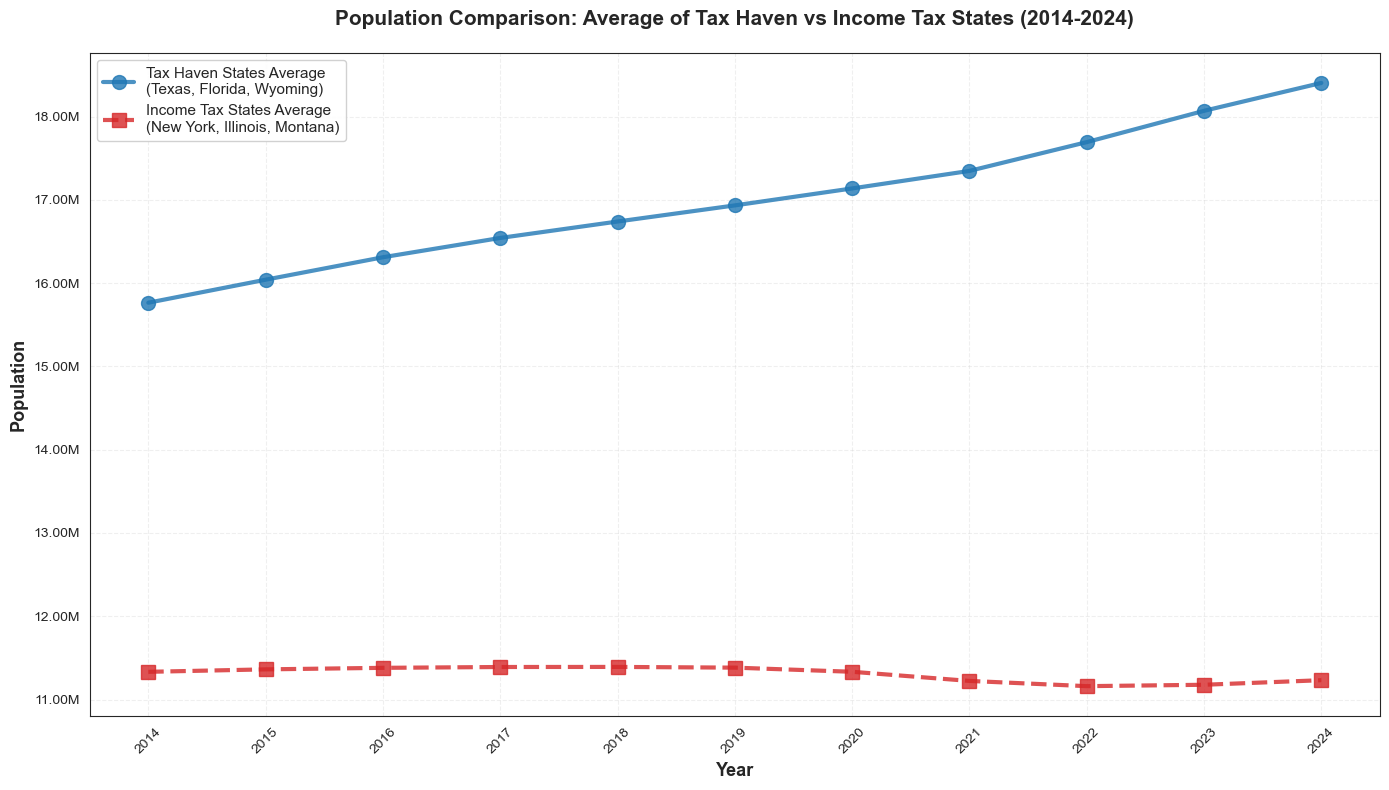

In [64]:
plot_average_comparison(state_merge, state_pairs, 'Population', year_range=(2014, 2024), save_path=None)

In [65]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# States with no income tax (as of recent years)
NO_INCOME_TAX_STATES = [
    'Alaska', 'Florida', 'Nevada', 'South Dakota',
    'Tennessee', 'Texas', 'Washington', 'Wyoming'
]

In [66]:
# Step 0: Create tax status indicator
state_merge['Has_Income_Tax'] = ~state_merge['State'].isin(NO_INCOME_TAX_STATES)
state_merge['Tax_Status'] = state_merge['Has_Income_Tax'].map({True: 'Income Tax', False: 'No Income Tax'})

# Calculate GDP per capita
state_merge['GDP_Per_Capita'] = state_merge['GDP_Total'] / state_merge['Population']

In [67]:
# Step 1: Normalize everything to 2014 = 100
def index_to_base_year(group, columns, base_year=2014):
    """
    Index values to base_year = 100 for each state
    """
    # Get base year values
    base_values = group[group['Year'] == base_year][columns].iloc[0]

    # Index all values
    for col in columns:
        group[f'{col}_Indexed'] = (group[col] / base_values[col]) * 100

    return group

# Columns to index
columns_to_index = ['GDP_Total', 'Population', 'GDP_Per_Capita', 'Housing_Price_Index']

# Apply indexing by state
df_indexed = state_merge.groupby('State', group_keys=False).apply(
    lambda x: index_to_base_year(x, columns_to_index, base_year=2014)
)

# Filter to annual data (Q4 only for cleaner visualization)
df_annual = df_indexed[df_indexed['Quarter'] == 4].copy()

# Calculate year-over-year changes
df_annual = df_annual.sort_values(['State', 'Year'])
for col in columns_to_index:
    indexed_col = f'{col}_Indexed'
    df_annual[f'{col}_Change'] = df_annual.groupby('State')[indexed_col].diff()

print("States with no income tax:")
print(df_annual[df_annual['Tax_Status'] == 'No Income Tax']['State'].unique())
print(f"\nNumber of no-income-tax states: {df_annual[df_annual['Tax_Status'] == 'No Income Tax']['State'].nunique()}")
print(f"Number of income-tax states: {df_annual[df_annual['Tax_Status'] == 'Income Tax']['State'].nunique()}")

States with no income tax:
['Alaska' 'Florida' 'Nevada' 'South Dakota' 'Tennessee' 'Texas'
 'Washington' 'Wyoming']

Number of no-income-tax states: 8
Number of income-tax states: 44


/var/folders/4j/zbynf7z51vjd7srq3yt48vpm0000gn/T/ipykernel_4571/3988759536.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_indexed = state_merge.groupby('State', group_keys=False).apply(


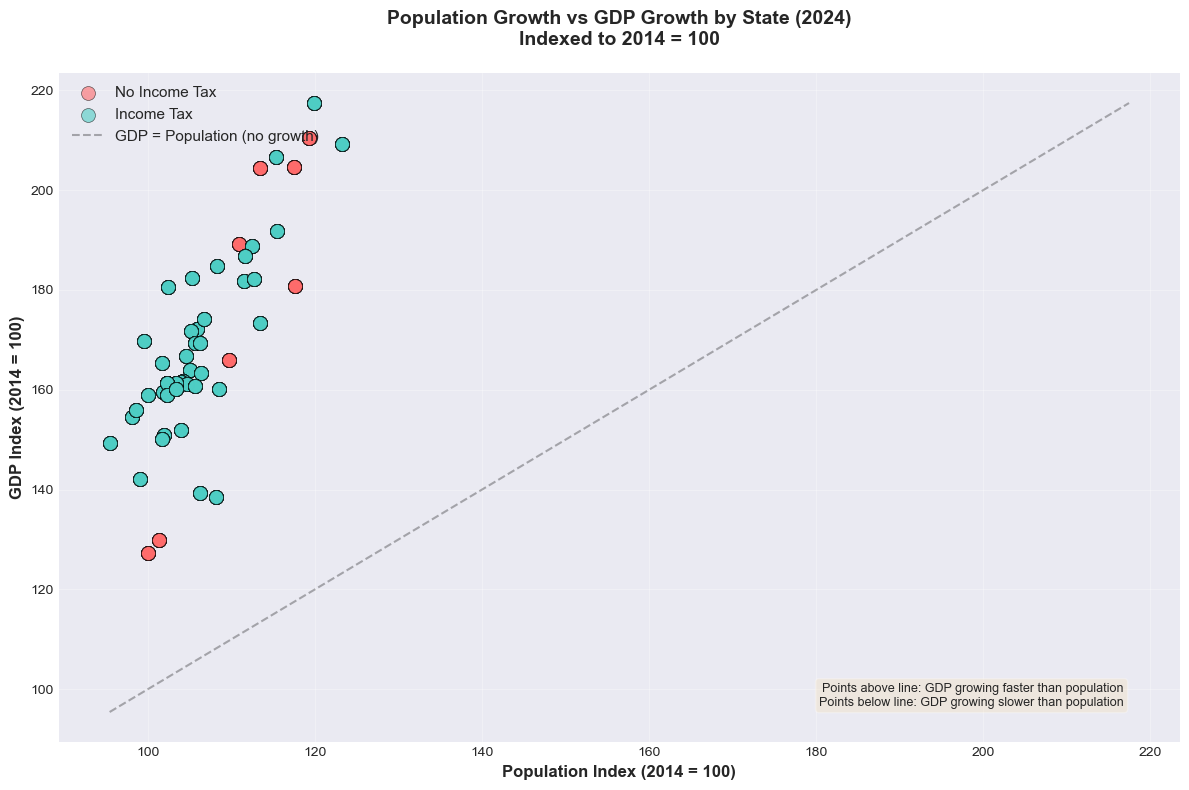

In [68]:
# Step 2: Create visualizations

# SLIDE 1: Population vs GDP (Indexed)
fig1, ax1 = plt.subplots(figsize=(12, 8))

# Filter to a specific year for cleaner visualization (e.g., 2023)
year_to_plot = df_annual['Year'].max()
df_plot = df_annual[df_annual['Year'] == year_to_plot].copy()

# Create scatter plot
for tax_status, color in [('No Income Tax', '#FF6B6B'), ('Income Tax', '#4ECDC4')]:
    mask = df_plot['Tax_Status'] == tax_status
    ax1.scatter(
        df_plot[mask]['Population_Indexed'],
        df_plot[mask]['GDP_Total_Indexed'],
        label=tax_status,
        alpha=0.6,
        s=100,
        color=color,
        edgecolors='black',
        linewidth=0.5
    )

# Add diagonal reference line (y=x)
min_val = min(df_plot['Population_Indexed'].min(), df_plot['GDP_Total_Indexed'].min())
max_val = max(df_plot['Population_Indexed'].max(), df_plot['GDP_Total_Indexed'].max())
ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='GDP = Population (no growth)')

ax1.set_xlabel('Population Index (2014 = 100)', fontsize=12, fontweight='bold')
ax1.set_ylabel('GDP Index (2014 = 100)', fontsize=12, fontweight='bold')
ax1.set_title(f'Population Growth vs GDP Growth by State ({year_to_plot})\nIndexed to 2014 = 100',
              fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)

# Add annotation
ax1.text(0.95, 0.05,
         'Points above line: GDP growing faster than population\nPoints below line: GDP growing slower than population',
         transform=ax1.transAxes,
         fontsize=9,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('slide1_population_vs_gdp.png', dpi=300, bbox_inches='tight')
plt.show()

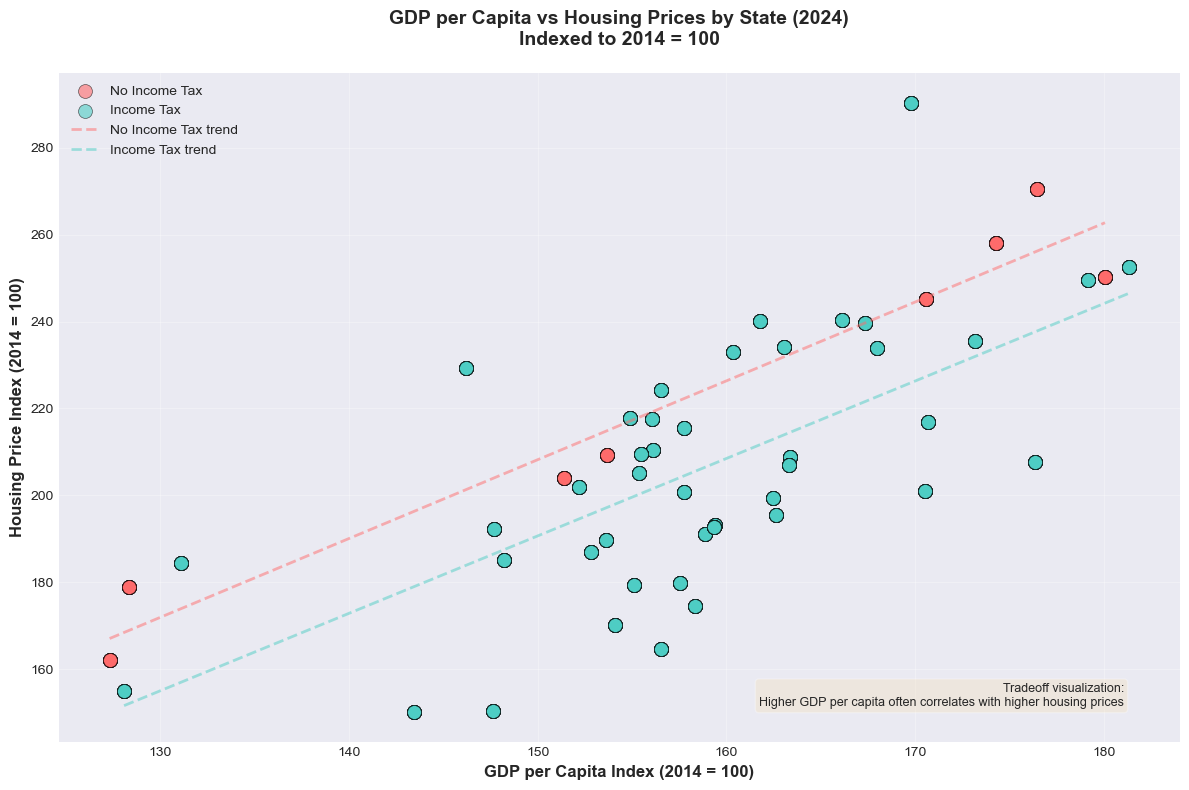

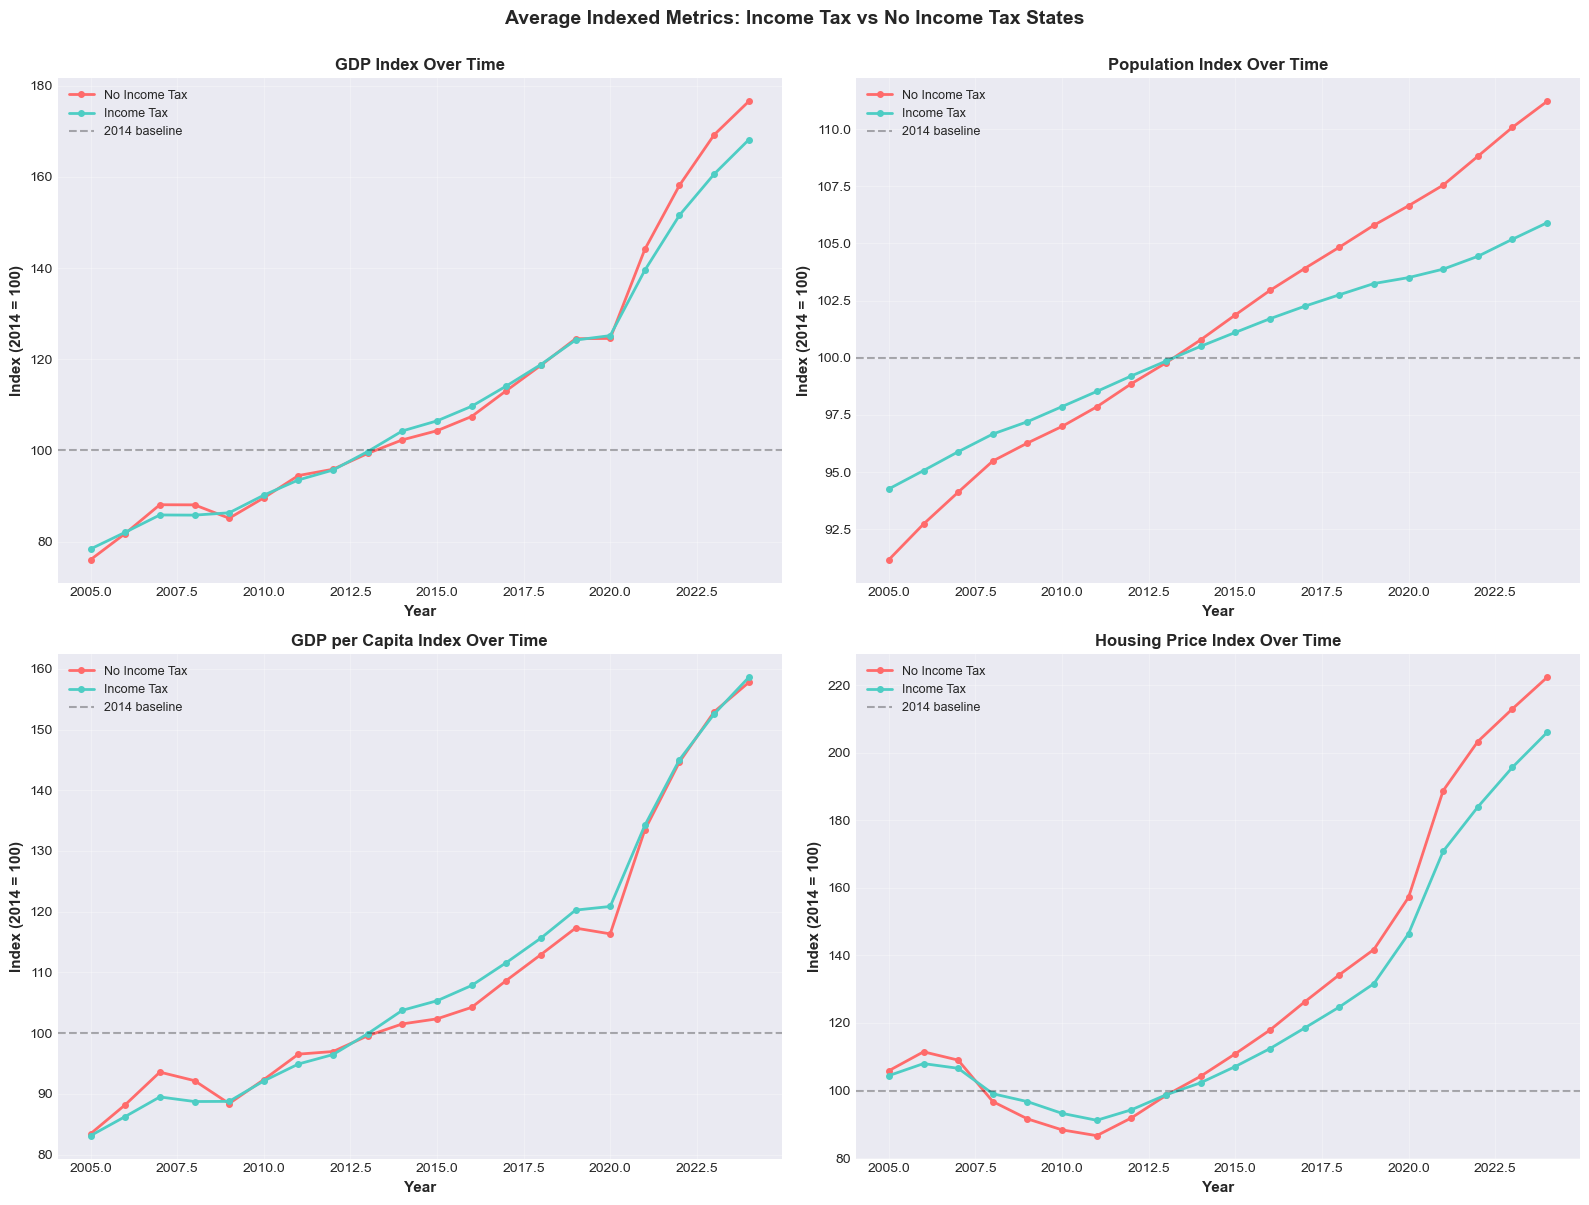


SUMMARY STATISTICS (Year: 2024)

No Income Tax States:
  GDP Index: Mean=176.59, Median=184.98
  Population Index: Mean=111.21, Median=112.18
  GDP per Capita Index: Mean=157.75, Median=162.12
  Housing Price Index: Mean=222.28, Median=227.22

Income Tax States:
  GDP Index: Mean=168.17, Median=163.34
  Population Index: Mean=105.91, Median=105.10
  GDP per Capita Index: Mean=158.59, Median=157.74
  Housing Price Index: Mean=205.98, Median=205.06


In [69]:
# SLIDE 2: GDP per Capita vs HPI (Indexed)
fig2, ax2 = plt.subplots(figsize=(12, 8))

# Create scatter plot
for tax_status, color in [('No Income Tax', '#FF6B6B'), ('Income Tax', '#4ECDC4')]:
    mask = df_plot['Tax_Status'] == tax_status
    ax2.scatter(
        df_plot[mask]['GDP_Per_Capita_Indexed'],
        df_plot[mask]['Housing_Price_Index_Indexed'],
        label=tax_status,
        alpha=0.6,
        s=100,
        color=color,
        edgecolors='black',
        linewidth=0.5
    )

ax2.set_xlabel('GDP per Capita Index (2014 = 100)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Housing Price Index (2014 = 100)', fontsize=12, fontweight='bold')
ax2.set_title(f'GDP per Capita vs Housing Prices by State ({year_to_plot})\nIndexed to 2014 = 100',
              fontsize=14, fontweight='bold', pad=20)
ax2.legend(loc='upper left', fontsize=11)
ax2.grid(True, alpha=0.3)

# Add trendlines with safety check
for tax_status, color in [('No Income Tax', '#FF6B6B'), ('Income Tax', '#4ECDC4')]:
    mask = df_plot['Tax_Status'] == tax_status
    x = df_plot[mask]['GDP_Per_Capita_Indexed'].values
    y = df_plot[mask]['Housing_Price_Index_Indexed'].values

    # Remove NaNs
    valid_mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[valid_mask]
    y = y[valid_mask]

    # Fit only if enough data and variation
    if len(x) > 1 and np.ptp(x) > 0 and np.ptp(y) > 0:
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        x_line = np.linspace(x.min(), x.max(), 100)
        ax2.plot(x_line, p(x_line), '--', color=color, alpha=0.5, linewidth=2,
                 label=f'{tax_status} trend')

ax2.legend(loc='upper left', fontsize=10)

# Add annotation about the tradeoff
ax2.text(0.95, 0.05,
         'Tradeoff visualization:\nHigher GDP per capita often correlates with higher housing prices',
         transform=ax2.transAxes,
         fontsize=9,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('slide2_gdp_per_capita_vs_hpi.png', dpi=300, bbox_inches='tight')
plt.show()


# BONUS: Time series comparison
fig3, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = [
    ('GDP_Total_Indexed', 'GDP Index'),
    ('Population_Indexed', 'Population Index'),
    ('GDP_Per_Capita_Indexed', 'GDP per Capita Index'),
    ('Housing_Price_Index_Indexed', 'Housing Price Index')
]

for idx, (col, title) in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    for tax_status, color in [('No Income Tax', '#FF6B6B'), ('Income Tax', '#4ECDC4')]:
        mask = df_annual['Tax_Status'] == tax_status
        data = df_annual[mask].groupby('Year')[col].mean()

        ax.plot(data.index, data.values, marker='o', linewidth=2,
                label=tax_status, color=color, markersize=4)

    ax.axhline(y=100, color='black', linestyle='--', alpha=0.3, label='2014 baseline')
    ax.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax.set_ylabel('Index (2014 = 100)', fontsize=11, fontweight='bold')
    ax.set_title(f'{title} Over Time', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Average Indexed Metrics: Income Tax vs No Income Tax States',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('slide3_time_series_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS (Year: {})".format(year_to_plot))
print("="*80)

for tax_status in ['No Income Tax', 'Income Tax']:
    print(f"\n{tax_status} States:")
    mask = df_plot['Tax_Status'] == tax_status

    for col, name in metrics:
        mean_val = df_plot[mask][col].mean()
        median_val = df_plot[mask][col].median()
        print(f"  {name}: Mean={mean_val:.2f}, Median={median_val:.2f}")


In [70]:
# Calculate formations per 100k for each year
df_annual['Formations_per_100k'] = (df_annual['Formations'] / df_annual['Population']) * 100000

# Also calculate the indexed version
def calculate_formations_per_100k_indexed(group, base_year=2014):
    """Calculate and index formations per 100k to base year"""
    # Calculate formations per 100k for all years
    group['Formations_per_100k_calc'] = (group['Formations'] / group['Population']) * 100000

    # Get base year value
    base_value = group[group['Year'] == base_year]['Formations_per_100k_calc'].iloc[0]

    # Index to base year = 100
    group['Formations_per_100k_Indexed'] = (group['Formations_per_100k_calc'] / base_value) * 100

    return group

df_annual = df_annual.groupby('State', group_keys=False).apply(
    lambda x: calculate_formations_per_100k_indexed(x, base_year=2014)
)

/var/folders/4j/zbynf7z51vjd7srq3yt48vpm0000gn/T/ipykernel_4571/1051140632.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_annual = df_annual.groupby('State', group_keys=False).apply(


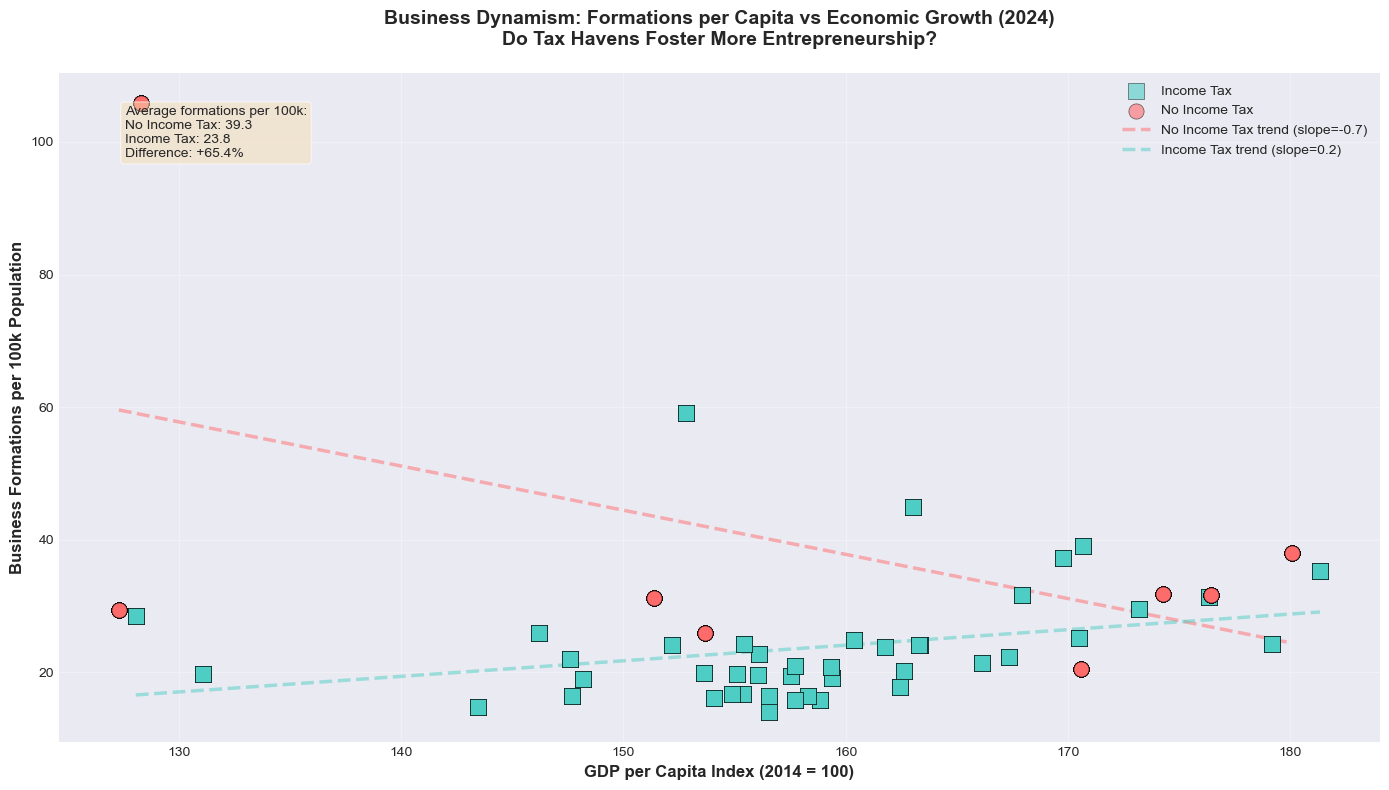

In [71]:
# Create the scatter plot
fig3, ax3 = plt.subplots(figsize=(14, 8))
year_to_plot = df_annual['Year'].max()
df_plot = df_annual[df_annual['Year'] == year_to_plot].copy()

# Plot Income Tax states FIRST (so they're in the background)
for tax_status, color, marker in [('Income Tax', '#4ECDC4', 's')]:  # Income tax first
    mask = df_plot['Tax_Status'] == tax_status
    data = df_plot[mask]

    ax3.scatter(
        data['GDP_Per_Capita_Indexed'],
        data['Formations_per_100k'],
        label=tax_status,
        alpha=0.6,
        s=120,
        color=color,
        edgecolors='black',
        linewidth=0.5,
        marker=marker,
        zorder=2  # Lower z-order (in back)
    )

# Plot No Income Tax states SECOND (so they're on top)
for tax_status, color, marker in [('No Income Tax', '#FF6B6B', 'o')]:  # No income tax second
    mask = df_plot['Tax_Status'] == tax_status
    data = df_plot[mask]

    ax3.scatter(
        data['GDP_Per_Capita_Indexed'],
        data['Formations_per_100k'],
        label=tax_status,
        alpha=0.6,
        s=120,
        color=color,
        edgecolors='black',
        linewidth=0.5,
        marker=marker,
        zorder=3  # Higher z-order (on top)
    )

# Add trendlines
for tax_status, color in [('No Income Tax', '#FF6B6B'), ('Income Tax', '#4ECDC4')]:
    mask = df_plot['Tax_Status'] == tax_status
    x = df_plot[mask]['GDP_Per_Capita_Indexed'].dropna().values
    y = df_plot[mask]['Formations_per_100k'].dropna().values

    if len(x) > 1:
        # Fit line
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)

        # Plot trendline
        x_line = np.linspace(x.min(), x.max(), 100)
        ax3.plot(x_line, p(x_line), '--', color=color, alpha=0.5, linewidth=2.5,
                 label=f'{tax_status} trend (slope={z[0]:.1f})',
                 zorder=1)  # Trendlines in the back

ax3.set_xlabel('GDP per Capita Index (2014 = 100)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Business Formations per 100k Population', fontsize=12, fontweight='bold')
ax3.set_title(f'Business Dynamism: Formations per Capita vs Economic Growth ({year_to_plot})\nDo Tax Havens Foster More Entrepreneurship?',
              fontsize=14, fontweight='bold', pad=20)
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3, zorder=0)  # Grid in the very back

# Calculate and display summary statistics
no_tax_mean = df_plot[df_plot['Tax_Status'] == 'No Income Tax']['Formations_per_100k'].mean()
tax_mean = df_plot[df_plot['Tax_Status'] == 'Income Tax']['Formations_per_100k'].mean()
difference_pct = ((no_tax_mean - tax_mean) / tax_mean) * 100

# Add annotation
annotation_text = f'Average formations per 100k:\n'
annotation_text += f'No Income Tax: {no_tax_mean:.1f}\n'
annotation_text += f'Income Tax: {tax_mean:.1f}\n'
annotation_text += f'Difference: {difference_pct:+.1f}%'

ax3.text(0.05, 0.95,
         annotation_text,
         transform=ax3.transAxes,
         fontsize=10,
         verticalalignment='top',
         horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('slide3_business_formations.png', dpi=300, bbox_inches='tight')
plt.show()

In [72]:
def plot_average_comparison(df, metric_name, year_range=(2020, 2025)):
    """
    Create a single plot comparing the AVERAGE of tax haven states vs AVERAGE of income tax states
    Uses ALL states (no pairing), quarterly data from 2020-2025

    Parameters:
    -----------
    df : DataFrame
        The main dataframe
    metric_name : str
        Name of the metric to plot (must be in METRICS dictionary)
    year_range : tuple
        (start_year, end_year) - default (2020, 2025)

    Returns:
    --------
    DataFrame with the averaged metric data
    """
    if metric_name not in METRICS:
        raise ValueError(f"Metric '{metric_name}' not found. Available: {list(METRICS.keys())}")

    metric_config = METRICS[metric_name]

    # States with no income tax as of 2020
    # Source: https://www.investopedia.com/financial-edge/0210/7-states-with-no-income-tax.aspx
    NO_INCOME_TAX_STATES = [
        'Alaska',
        'Florida',
        'Nevada',
        'South Dakota',
        'Tennessee',  # Eliminated income tax fully by 2021, but had no wage tax in 2020
        'Texas',
        'Washington',
        'Wyoming'
    ]
    # Note: New Hampshire only taxes dividends/interest, not wages
    # Tennessee was phasing out and had minimal tax in 2020

    # Filter data
    df_filtered = df[
        (df['Year'] >= year_range[0]) &
        (df['Year'] <= year_range[1]) &
        (df['State'] != 'US Total') &  # Exclude US total
        (df['State'] != 'Puerto Rico') &  # Exclude US total
        (df['State'] != 'District of Columbia')  # Exclude DC
    ].copy()

    # Create tax status
    df_filtered['Tax_Status'] = df_filtered['State'].apply(
        lambda x: 'No Income Tax' if x in NO_INCOME_TAX_STATES else 'Income Tax'
    )

    # Create Year-Quarter column for x-axis
    df_filtered['Year_Quarter'] = df_filtered['Year'].astype(str) + ' Q' + df_filtered['Quarter'].astype(str)
    df_filtered['Year_Quarter_Numeric'] = df_filtered['Year'] + (df_filtered['Quarter'] - 1) / 4

    # Calculate metric if it doesn't exist in the dataframe
    if metric_name not in df_filtered.columns:
        # Add logic here to calculate the metric based on metric_name
        # For example, if it's a per capita metric:
        if 'per_capita' in metric_name.lower():
            base_metric = metric_name.replace('_per_capita', '')
            if base_metric in df_filtered.columns:
                df_filtered[metric_name] = df_filtered[base_metric] / df_filtered['Population']

    # Calculate averages for each group by Year and Quarter
    haven_avg = df_filtered[df_filtered['Tax_Status'] == 'No Income Tax'].groupby(
        ['Year', 'Quarter', 'Year_Quarter', 'Year_Quarter_Numeric']
    )[metric_name].mean().reset_index()
    haven_avg.columns = ['Year', 'Quarter', 'Year_Quarter', 'Year_Quarter_Numeric', 'Average']
    haven_avg['Group'] = 'No Income Tax States (Avg)'

    non_haven_avg = df_filtered[df_filtered['Tax_Status'] == 'Income Tax'].groupby(
        ['Year', 'Quarter', 'Year_Quarter', 'Year_Quarter_Numeric']
    )[metric_name].mean().reset_index()
    non_haven_avg.columns = ['Year', 'Quarter', 'Year_Quarter', 'Year_Quarter_Numeric', 'Average']
    non_haven_avg['Group'] = 'Income Tax States (Avg)'

    # Combine for return
    combined_data = pd.concat([haven_avg, non_haven_avg], ignore_index=True)

    # Create single plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    # Plot lines
    ax.plot(haven_avg['Year_Quarter_Numeric'], haven_avg['Average'],
            marker='o', linewidth=2.5, markersize=6,
            label=f'No Income Tax States (n={len(NO_INCOME_TAX_STATES)})\n{", ".join(NO_INCOME_TAX_STATES)}',
            color='#FF6B6B', alpha=0.8)

    # Count income tax states
    income_tax_states = df_filtered[df_filtered['Tax_Status'] == 'Income Tax']['State'].nunique()

    ax.plot(non_haven_avg['Year_Quarter_Numeric'], non_haven_avg['Average'],
            marker='s', linewidth=2.5, markersize=6,
            label=f'Income Tax States (n={income_tax_states})',
            color='#4ECDC4', linestyle='--', alpha=0.8)

    # Formatting
    ax.set_xlabel('Year-Quarter', fontsize=13, fontweight='bold')
    ax.set_ylabel(metric_config['ylabel'], fontsize=13, fontweight='bold')
    ax.set_title(f'{metric_config["title"]}: No Income Tax vs Income Tax States ({year_range[0]}-{year_range[1]})',
                 fontsize=15, fontweight='bold', pad=20)
    ax.legend(loc='best', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.ticklabel_format(style='plain', axis='y')

    # Format y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(metric_config['format']))

    # Set x-axis to show quarters
    # Create tick positions for each year's Q1
    year_ticks = []
    year_labels = []
    for year in range(year_range[0], year_range[1] + 1):
        year_ticks.append(year)
        year_labels.append(str(year))

    ax.set_xticks(year_ticks)
    ax.set_xticklabels(year_labels, rotation=0)

    # Add minor ticks for quarters
    quarter_ticks = []
    for year in range(year_range[0], year_range[1] + 1):
        for q in range(1, 5):
            quarter_ticks.append(year + (q - 1) / 4)
    ax.set_xticks(quarter_ticks, minor=True)
    ax.grid(True, alpha=0.15, linestyle=':', which='minor')

    plt.tight_layout()

    # Print summary statistics
    print(f"\n{'='*80}")
    print(f"Summary Statistics for {metric_config['title']}")
    print(f"{'='*80}")
    print(f"\nNo Income Tax States ({len(NO_INCOME_TAX_STATES)} states):")
    print(f"  Average: {haven_avg['Average'].mean():.2f}")
    print(f"  Min: {haven_avg['Average'].min():.2f}")
    print(f"  Max: {haven_avg['Average'].max():.2f}")

    print(f"\nIncome Tax States ({income_tax_states} states):")
    print(f"  Average: {non_haven_avg['Average'].mean():.2f}")
    print(f"  Min: {non_haven_avg['Average'].min():.2f}")
    print(f"  Max: {non_haven_avg['Average'].max():.2f}")

    difference = haven_avg['Average'].mean() - non_haven_avg['Average'].mean()
    pct_difference = (difference / non_haven_avg['Average'].mean()) * 100
    print(f"\nDifference: {difference:.2f} ({pct_difference:+.1f}%)")
    print(f"{'='*80}\n")

    return combined_data


Summary Statistics for GDP Per Capita

No Income Tax States (8 states):
  Average: 0.08
  Min: 0.06
  Max: 0.09

Income Tax States (42 states):
  Average: 0.07
  Min: 0.06
  Max: 0.08

Difference: 0.01 (+9.7%)



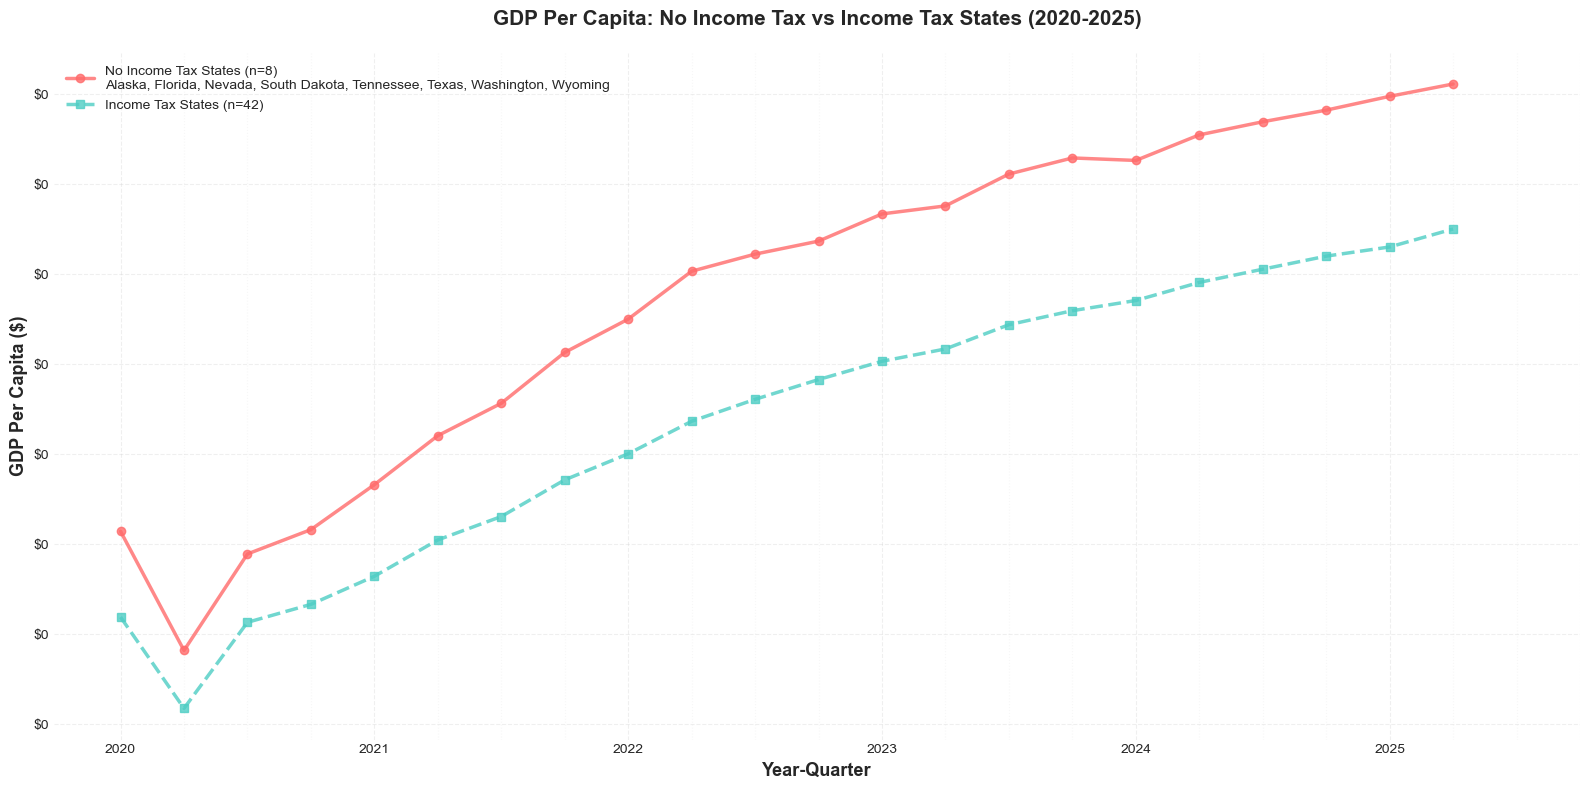

In [76]:
result = plot_average_comparison(state_merge, 'GDP_Per_Capita')
plt.show()


Summary Statistics for Unemployment Rate

No Income Tax States (8 states):
  Average: 4.73
  Min: 3.47
  Max: 12.68

Income Tax States (42 states):
  Average: 4.38
  Min: 3.10
  Max: 11.66

Difference: 0.34 (+7.8%)



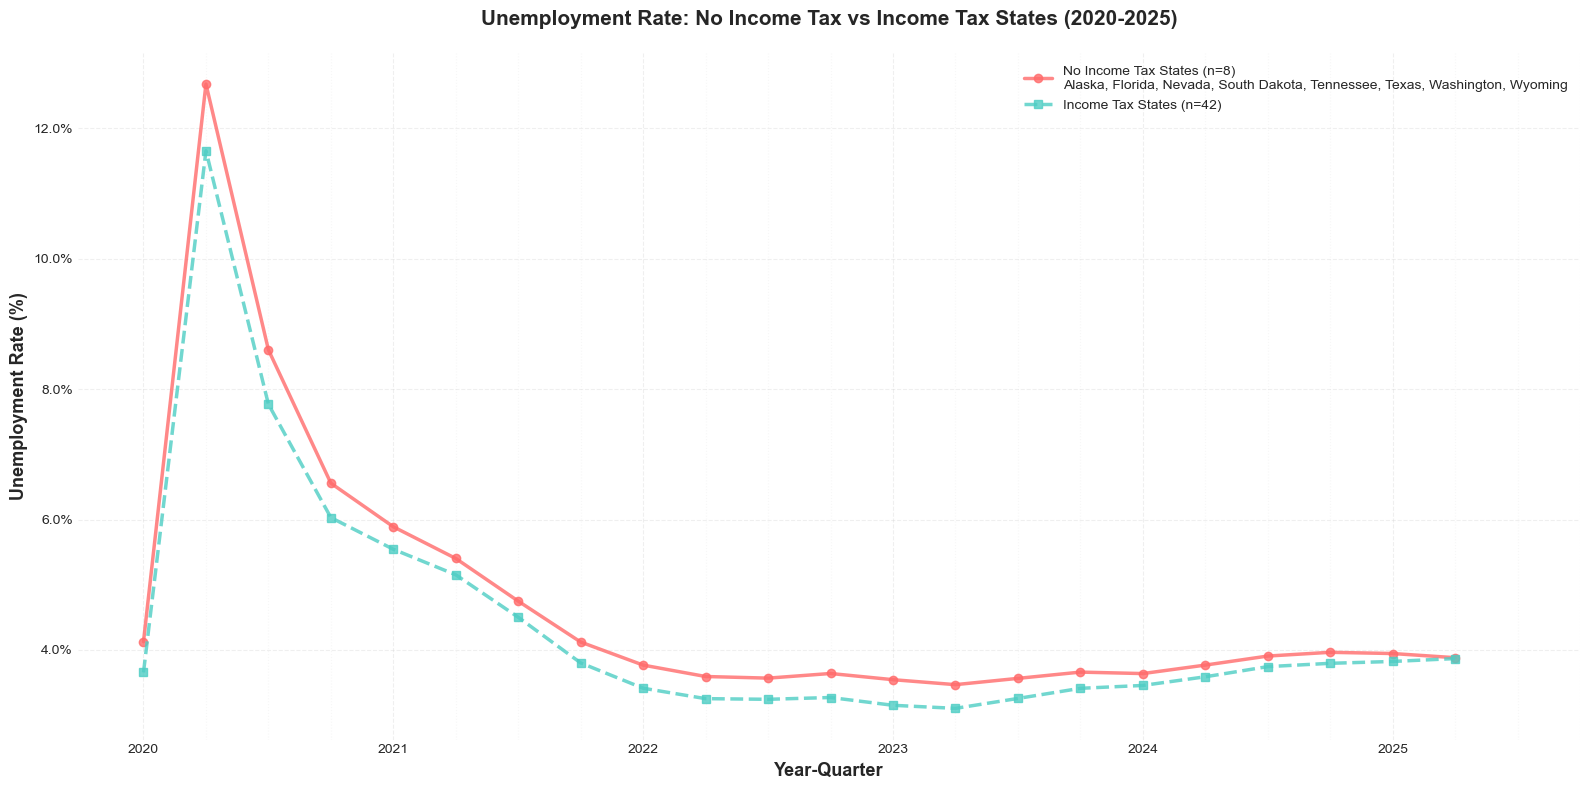

In [78]:
result = plot_average_comparison(state_merge, 'Unemployment_Rate')


Summary Statistics for Business Formations

No Income Tax States (8 states):
  Average: 2523.86
  Min: 1710.00
  Max: 2809.00

Income Tax States (42 states):
  Average: 1378.50
  Min: 964.93
  Max: 1488.69

Difference: 1145.35 (+83.1%)



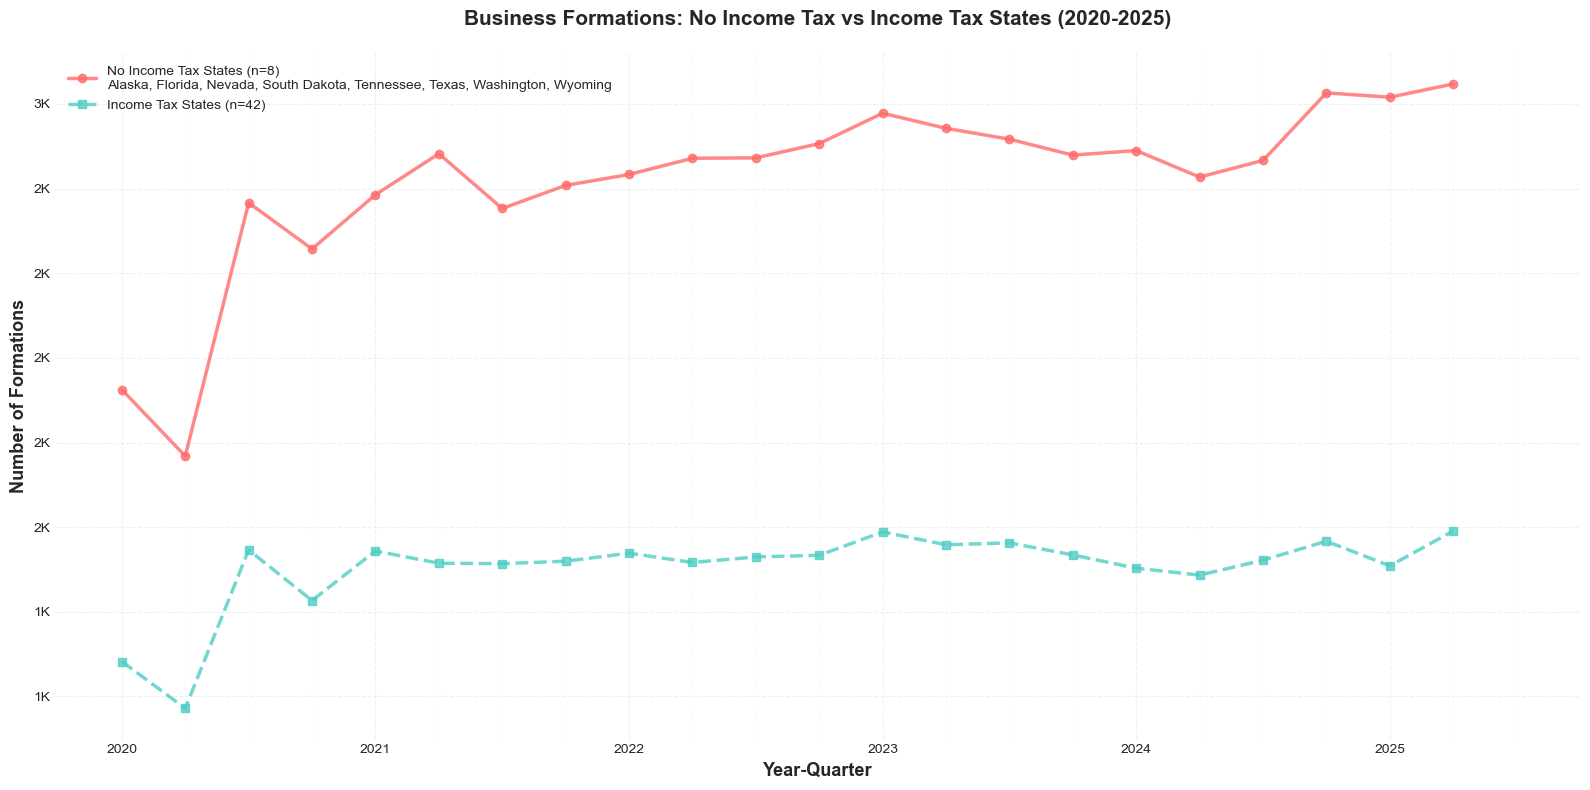

In [80]:
result = plot_average_comparison(state_merge, 'Formations')


Summary Statistics for Total Civilian Labor Force

No Income Tax States (8 states):
  Average: 4440528.40
  Min: 4049414.75
  Max: 4669501.00

Income Tax States (42 states):
  Average: 3080736.79
  Min: 2944865.17
  Max: 3163683.07

Difference: 1359791.61 (+44.1%)



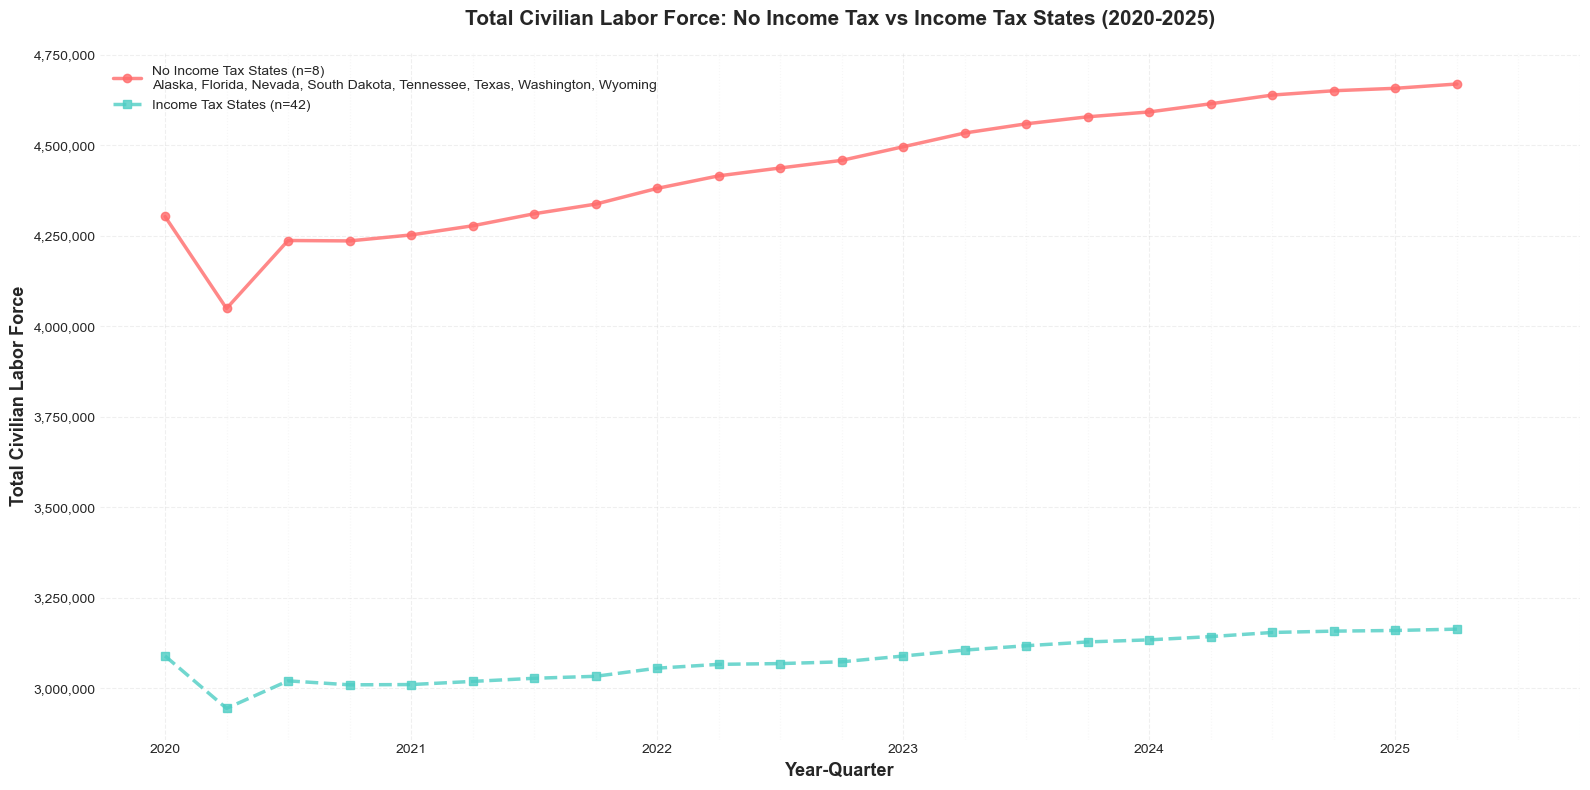

In [84]:
result = plot_average_comparison(state_merge, 'Total Civilian Labor Force')

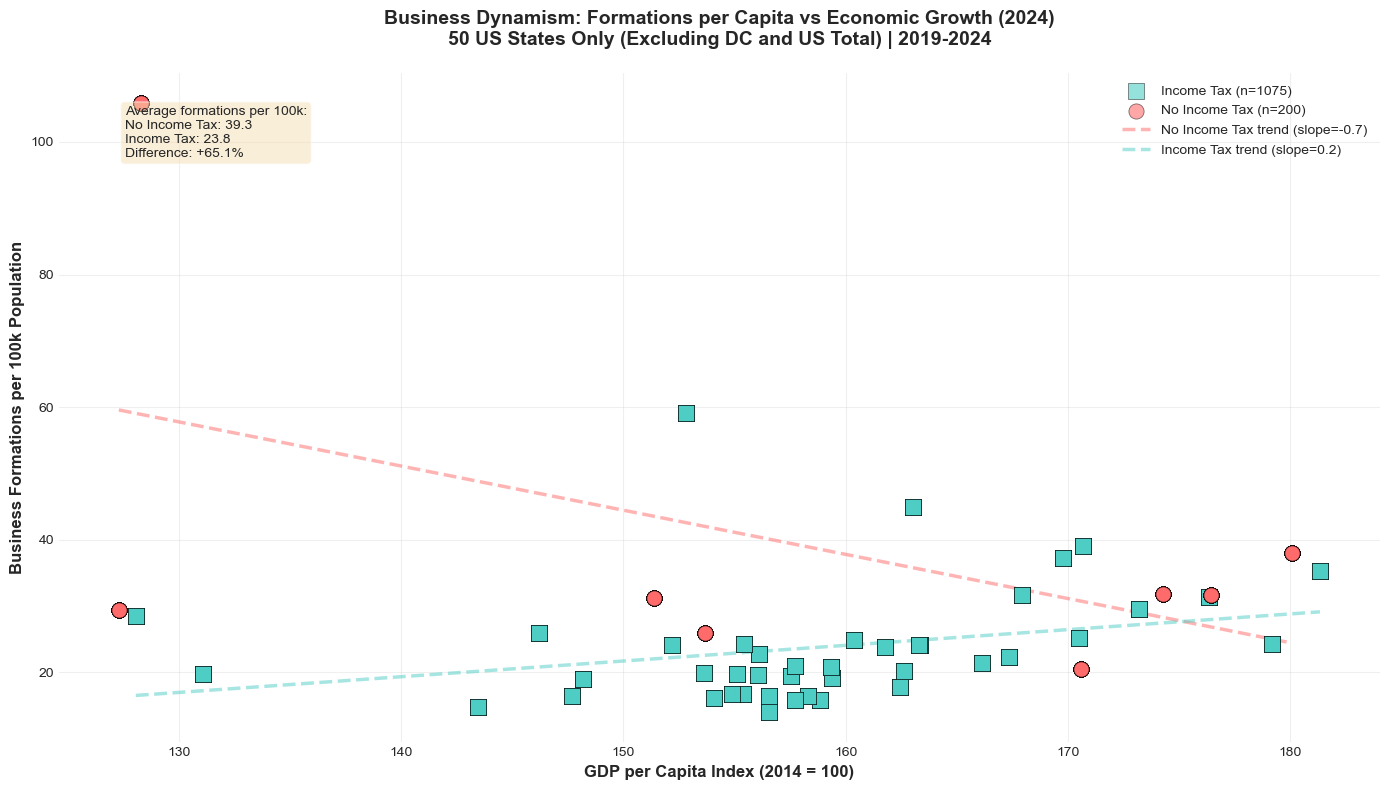


Data Summary:
- Years included: 2019-2024
- States with No Income Tax: 8
- States with Income Tax: 43
- Total states: 51
- Year plotted: 2024


In [86]:
# Filter data: Remove DC and US totals, limit to 2019-2024
df_filtered = df_annual[
    (df_annual['State'] != 'District of Columbia') &
    (df_annual['State'] != 'United States') &
    (df_annual['Year'] >= 2019) &
    (df_annual['Year'] <= 2024)
].copy()

# Create the scatter plot
fig3, ax3 = plt.subplots(figsize=(14, 8))
year_to_plot = df_filtered['Year'].max()
df_plot = df_filtered[df_filtered['Year'] == year_to_plot].copy()

# Plot Income Tax states FIRST (so they're in the background)
for tax_status, color, marker in [('Income Tax', '#4ECDC4', 's')]:  # Income tax first
    mask = df_plot['Tax_Status'] == tax_status
    data = df_plot[mask]

    ax3.scatter(
        data['GDP_Per_Capita_Indexed'],
        data['Formations_per_100k'],
        label=f'{tax_status} (n={len(data)})',
        alpha=0.6,
        s=120,
        color=color,
        edgecolors='black',
        linewidth=0.5,
        marker=marker,
        zorder=2  # Lower z-order (in back)
    )

# Plot No Income Tax states SECOND (so they're on top)
for tax_status, color, marker in [('No Income Tax', '#FF6B6B', 'o')]:  # No income tax second
    mask = df_plot['Tax_Status'] == tax_status
    data = df_plot[mask]

    ax3.scatter(
        data['GDP_Per_Capita_Indexed'],
        data['Formations_per_100k'],
        label=f'{tax_status} (n={len(data)})',
        alpha=0.6,
        s=120,
        color=color,
        edgecolors='black',
        linewidth=0.5,
        marker=marker,
        zorder=3  # Higher z-order (on top)
    )

# Add trendlines
for tax_status, color in [('No Income Tax', '#FF6B6B'), ('Income Tax', '#4ECDC4')]:
    mask = df_plot['Tax_Status'] == tax_status
    x = df_plot[mask]['GDP_Per_Capita_Indexed'].dropna().values
    y = df_plot[mask]['Formations_per_100k'].dropna().values

    if len(x) > 1:
        # Fit line
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)

        # Plot trendline
        x_line = np.linspace(x.min(), x.max(), 100)
        ax3.plot(x_line, p(x_line), '--', color=color, alpha=0.5, linewidth=2.5,
                 label=f'{tax_status} trend (slope={z[0]:.1f})',
                 zorder=1)  # Trendlines in the back

ax3.set_xlabel('GDP per Capita Index (2014 = 100)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Business Formations per 100k Population', fontsize=12, fontweight='bold')
ax3.set_title(f'Business Dynamism: Formations per Capita vs Economic Growth ({year_to_plot})\n50 US States Only (Excluding DC and US Total) | 2019-2024',
              fontsize=14, fontweight='bold', pad=20)
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3, zorder=0)  # Grid in the very back

# Calculate and display summary statistics
no_tax_mean = df_plot[df_plot['Tax_Status'] == 'No Income Tax']['Formations_per_100k'].mean()
tax_mean = df_plot[df_plot['Tax_Status'] == 'Income Tax']['Formations_per_100k'].mean()
difference_pct = ((no_tax_mean - tax_mean) / tax_mean) * 100

# Add annotation
annotation_text = f'Average formations per 100k:\n'
annotation_text += f'No Income Tax: {no_tax_mean:.1f}\n'
annotation_text += f'Income Tax: {tax_mean:.1f}\n'
annotation_text += f'Difference: {difference_pct:+.1f}%'

ax3.text(0.05, 0.95,
         annotation_text,
         transform=ax3.transAxes,
         fontsize=10,
         verticalalignment='top',
         horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary of what was filtered
print(f"\nData Summary:")
print(f"- Years included: 2019-2024")
print(f"- States with No Income Tax: {df_plot[df_plot['Tax_Status'] == 'No Income Tax']['State'].nunique()}")
print(f"- States with Income Tax: {df_plot[df_plot['Tax_Status'] == 'Income Tax']['State'].nunique()}")
print(f"- Total states: {df_plot['State'].nunique()}")
print(f"- Year plotted: {year_to_plot}")

In [88]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   State                                   1054 non-null   object 
 1   Year                                    1054 non-null   int64  
 2   Total Population                        1050 non-null   float64
 3   White Alone                             1040 non-null   float64
 4   Black Alone                             1040 non-null   float64
 5   American Indian or Alaskan Native       1040 non-null   float64
 6   Asian Alone                             1040 non-null   float64
 7   Hawaiian or Pacific Islander Alone      1040 non-null   float64
 8   Two or More Races                       1040 non-null   float64
 9   Not Hispanic                            1040 non-null   float64
 10  Hispanic                                1040 non-null   floa

KeyError: 'GDP_Per_Capita_Indexed'

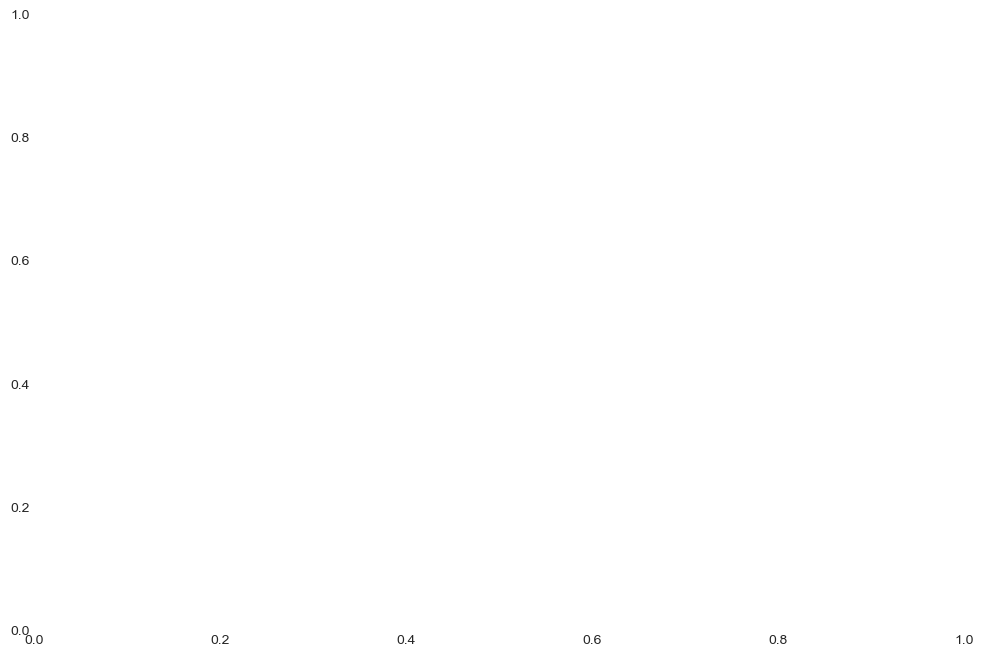

In [90]:
# Filter data: Remove US Total, DC, Puerto Rico, and limit to 2019-2024
df_filtered = state_merge[
    (state_merge['State'] != 'United States') &
    (state_merge['State'] != 'District of Columbia') &
    (state_merge['State'] != 'Puerto Rico') &
    (state_merge['Year'] >= 2019) &
    (state_merge['Year'] <= 2024)
].copy()

# Get the most recent year for scatter plots
year_to_plot = df_filtered['Year'].max()
df_plot = df_filtered[df_filtered['Year'] == year_to_plot].copy()

# SLIDE 2: GDP per Capita vs HPI (Indexed)
fig2, ax2 = plt.subplots(figsize=(12, 8))

# Plot Income Tax states FIRST (background)
for tax_status, color, marker in [('Income Tax', '#4ECDC4', 's')]:
    mask = df_plot['Tax_Status'] == tax_status
    data = df_plot[mask]
    ax2.scatter(
        data['GDP_Per_Capita_Indexed'],
        data['Housing_Price_Index_Indexed'],
        label=f'{tax_status} (n={len(data)})',
        alpha=0.6,
        s=100,
        color=color,
        edgecolors='black',
        linewidth=0.5,
        marker=marker,
        zorder=2
    )

# Plot No Income Tax states SECOND (foreground)
for tax_status, color, marker in [('No Income Tax', '#FF6B6B', 'o')]:
    mask = df_plot['Tax_Status'] == tax_status
    data = df_plot[mask]
    ax2.scatter(
        data['GDP_Per_Capita_Indexed'],
        data['Housing_Price_Index_Indexed'],
        label=f'{tax_status} (n={len(data)})',
        alpha=0.6,
        s=100,
        color=color,
        edgecolors='black',
        linewidth=0.5,
        marker=marker,
        zorder=3
    )

ax2.set_xlabel('GDP per Capita Index (2014 = 100)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Housing Price Index (2014 = 100)', fontsize=12, fontweight='bold')
ax2.set_title(f'GDP per Capita vs Housing Prices by State ({year_to_plot})\n50 US States Only | 2019-2024 | Indexed to 2014 = 100',
              fontsize=14, fontweight='bold', pad=20)
ax2.legend(loc='upper left', fontsize=11)
ax2.grid(True, alpha=0.3, zorder=0)

# Add trendlines
for tax_status, color in [('No Income Tax', '#FF6B6B'), ('Income Tax', '#4ECDC4')]:
    mask = df_plot['Tax_Status'] == tax_status
    x = df_plot[mask]['GDP_Per_Capita_Indexed'].dropna().values
    y = df_plot[mask]['Housing_Price_Index_Indexed'].dropna().values

    if len(x) > 1:
        # Fit line
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)

        # Plot trendline
        x_line = np.linspace(x.min(), x.max(), 100)
        ax2.plot(x_line, p(x_line), '--', color=color, alpha=0.5, linewidth=2,
                 label=f'{tax_status} trend (slope={z[0]:.2f})',
                 zorder=1)

ax2.legend(loc='upper left', fontsize=10)

# Add annotation about the tradeoff
ax2.text(0.95, 0.05,
         'Tradeoff visualization:\nHigher GDP per capita often correlates with higher housing prices',
         transform=ax2.transAxes,
         fontsize=9,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

In [ ]:
# Step 0: Filter data - Remove US Total, United States, DC, and limit to 2019-2024
df_filtered = state_merge[
    (state_merge['State'] != 'United States') &
    (state_merge['State'] != 'District of Columbia') &
    (state_merge['State'] != 'Puerto Rico') &  # Added for good measure
    (state_merge['Year'] >= 2019) &
    (state_merge['Year'] <= 2024)
].copy()

print(f"Data filtered: {len(df_filtered):,} records")
print(f"Years: 2019-2024")
print(f"States included: {df_filtered['State'].nunique()}")
print(f"Excluded: US Total, District of Columbia, Puerto Rico\n")

# Step 1: Normalize everything to 2019 = 100
def index_to_base_year(group, columns, base_year=2019):
    """
    Index values to base_year = 100 for each state
    """
    # Check if base year exists for this state
    if base_year not in group['Year'].values:
        print(f"Warning: Base year {base_year} not found for state {group['State'].iloc[0]}")
        return group

    # Get base year values
    base_values = group[group['Year'] == base_year][columns].iloc[0]

    # Index all values
    for col in columns:
        group[f'{col}_Indexed'] = (group[col] / base_values[col]) * 100

    return group

# Columns to index
columns_to_index = ['GDP_Total', 'Population', 'GDP_Per_Capita', 'Housing_Price_Index']

# Apply indexing by state
df_indexed = df_filtered.groupby('State', group_keys=False).apply(
    lambda x: index_to_base_year(x, columns_to_index, base_year=2019)
)

# Filter to annual data (Q4 only for cleaner visualization)
df_annual = df_indexed[df_indexed['Quarter'] == 4].copy()

# Calculate year-over-year changes
df_annual = df_annual.sort_values(['State', 'Year'])
for col in columns_to_index:
    indexed_col = f'{col}_Indexed'
    df_annual[f'{col}_Change'] = df_annual.groupby('State')[indexed_col].diff()

print("="*80)
print("States with no income tax:")
print(df_annual[df_annual['Tax_Status'] == 'No Income Tax']['State'].unique())
print(f"\nNumber of no-income-tax states: {df_annual[df_annual['Tax_Status'] == 'No Income Tax']['State'].nunique()}")
print(f"Number of income-tax states: {df_annual[df_annual['Tax_Status'] == 'Income Tax']['State'].nunique()}")
print(f"Total states: {df_annual['State'].nunique()}")
print("="*80 + "\n")

# SLIDE 2: GDP per Capita vs HPI (Indexed)
fig2, ax2 = plt.subplots(figsize=(12, 8))

# Create scatter plot
for tax_status, color in [('No Income Tax', '#FF6B6B'), ('Income Tax', '#4ECDC4')]:
    mask = df_plot['Tax_Status'] == tax_status
    ax2.scatter(
        df_plot[mask]['GDP_Per_Capita_Indexed'],
        df_plot[mask]['Housing_Price_Index_Indexed'],
        label=tax_status,
        alpha=0.6,
        s=100,
        color=color,
        edgecolors='black',
        linewidth=0.5
    )

ax2.set_xlabel('GDP per Capita Index (2019 = 100)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Housing Price Index (2019 = 100)', fontsize=12, fontweight='bold')
ax2.set_title(f'GDP per Capita vs Housing Prices by State ({year_to_plot})\nIndexed to 2019 = 100',
              fontsize=14, fontweight='bold', pad=20)
ax2.legend(loc='upper left', fontsize=11)
ax2.grid(True, alpha=0.3)

# Add trendlines
for tax_status, color in [('No Income Tax', '#FF6B6B'), ('Income Tax', '#4ECDC4')]:
    mask = df_plot['Tax_Status'] == tax_status
    x = df_plot[mask]['GDP_Per_Capita_Indexed'].values
    y = df_plot[mask]['Housing_Price_Index_Indexed'].values

    # Fit line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)

    # Plot trendline
    x_line = np.linspace(x.min(), x.max(), 100)
    ax2.plot(x_line, p(x_line), '--', color=color, alpha=0.5, linewidth=2,
             label=f'{tax_status} trend')

ax2.legend(loc='upper left', fontsize=10)

# Add annotation about the tradeoff
ax2.text(0.95, 0.05,
         'Tradeoff visualization:\nHigher GDP per capita often correlates with higher housing prices',
         transform=ax2.transAxes,
         fontsize=9,
         verticalalignment='bottom',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

In [ ]:
# Define the no income tax states
no_income_tax_states = ['Alaska', 'Florida', 'Nevada', 'South Dakota',
                        'Tennessee', 'Texas', 'Washington', 'Wyoming']

# Create a flag for no income tax states
state_merge['No_Income_Tax'] = state_merge['State'].isin(no_income_tax_states)

# Create Year-Quarter column for grouping
state_merge['Year_Quarter'] = state_merge['Year'].astype(str) + '-Q' + state_merge['Quarter'].astype(str)

# Group by Year-Quarter and tax status, calculate average
grouped = state_merge.groupby(['Year', 'No_Income_Tax'])['Total Civilian Labor Force'].mean().reset_index()
grouped['Year_Quarter'] = grouped['Year'].astype(str)

# Sort by Year and Quarter
grouped = grouped.sort_values(['Year'])

# Separate data for the two groups
no_tax = grouped[grouped['No_Income_Tax'] == True].reset_index(drop=True)
income_tax = grouped[grouped['No_Income_Tax'] == False].reset_index(drop=True)

# Create the plot
plt.figure(figsize=(14, 7))

# Plot lines
plt.plot(no_tax.index, no_tax['Total Civilian Labor Force'],
         marker='o', linewidth=2.5, markersize=7,
         color='#E57373', label='No Income Tax States (n=8)\nAlaska, Florida, Nevada, South Dakota, Tennessee, Texas, Washington, Wyoming')

plt.plot(income_tax.index, income_tax['Total Civilian Labor Force'],
         marker='s', linewidth=2.5, markersize=6, linestyle='--',
         color='#4DB6AC', label='Income Tax States (n=42)')

# Customize plot
plt.title('Average Civilian Labor Force: No Income Tax vs Income Tax States (2020-2025)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Year-Quarter', fontsize=12)
plt.ylabel('Average Civilian Labor Force', fontsize=12)

# Set y-axis to start from 0
plt.ylim(0, None)

# Set x-axis labels (show only years)
x_ticks = []
x_labels = []
for i in range(len(no_tax)):
    year = no_tax.iloc[i]['Year']

plt.xticks(x_ticks, x_labels)

# Add grid
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.gca().set_facecolor('#F5F5F5')

# Format y-axis with commas
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Add legend
plt.legend(loc='upper left', fontsize=10, framealpha=0.95)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Define tax haven states
tax_havens = ['Alaska', 'Florida', 'Nevada', 'South Dakota', 'Tennessee', 'Texas', 'Washington', 'Wyoming']

# States to exclude
exclude_states = ['District of Columbia', 'Puerto Rico', 'United States', 'US Total']

# Filter data for years 2014-2024
df_filtered = state_merge[(state_merge['Year'] >= 2014) & (state_merge['Year'] <= 2024)].copy()

# Exclude specified states
df_filtered = df_filtered[~df_filtered['State'].isin(exclude_states)]

# Calculate GDP per capita (GDP_Total is in millions, Population is in actual count)
# Convert from millions to thousands: (GDP_Total * 1000) / Population
df_filtered['GDP_per_capita'] = (df_filtered['GDP_Total'] * 1000) / df_filtered['Population']

# Create tax haven indicator
df_filtered['Is_Tax_Haven'] = df_filtered['State'].isin(tax_havens)

# Group by Year and tax haven status, calculate mean GDP per capita
grouped = df_filtered.groupby(['Year', 'Is_Tax_Haven'])['GDP_per_capita'].mean().reset_index()

# Separate tax havens and other states
tax_haven_data = grouped[grouped['Is_Tax_Haven'] == True]
other_states_data = grouped[grouped['Is_Tax_Haven'] == False]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(tax_haven_data['Year'], tax_haven_data['GDP_per_capita'],
         marker='o', linewidth=2, label='Tax Haven States', color='#2E86AB')
plt.plot(other_states_data['Year'], other_states_data['GDP_per_capita'],
         marker='s', linewidth=2, label='Other States', color='#A23B72')

plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP per Capita (Thousands of Dollars)', fontsize=12)
plt.title('Average GDP per Capita: Tax Haven States vs Other States (2014-2024)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(2014, 2025))
plt.ylim(bottom=0)  # Set y-axis to start from 0
plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print("\nAverage GDP per Capita (in thousands of dollars):")
print("\nTax Haven States:")
print(tax_haven_data[['Year', 'GDP_per_capita']])
print("\nOther States:")
print(other_states_data[['Year', 'GDP_per_capita']])

In [ ]:
# Load the tax dataset
# Ensure the path matches the file location in your Colab environment
df = pd.read_csv("/Users/apple/Downloads/1. DatathonMasterStateTaxData_2004_2025Q2.csv")

# 1. Filter for the specified timeframe: 2020 through Q2 2025
df = df[df['Year'] >= 2020]
df = df[~((df['Year'] == 2025) & (df['Quarter'] > 2))]

# EXCLUDE National aggregates AND District of Columbia
# This ensures only the 50 actual states are used in the comparison
df = df[~df['State'].isin(['US Total', 'District of Columbia'])]

# 2. Categorize the states into your two custom groups
tax_haven_list = ['Alaska', 'Florida', 'Nevada', 'Texas', 'Wyoming', 'South Dakota', 'Tennessee', 'Washington ']
df['Group'] = df['State'].apply(lambda x: 'Tax Haven States' if x in tax_haven_list else 'Other States')

# 3. Identify and sum specific tax amounts per row for easier aggregation
# General Sales = T09
df['Sales_Amt'] = df.apply(lambda x: x['Amount'] if x['Tax_Code'] == 'T09' else 0, axis=1)

# Excise Tax = T10 through T19
excise_codes = ['T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T19', 'T59']
df['Excise_Amt'] = df.apply(lambda x: x['Amount'] if x['Tax_Code'] in excise_codes else 0, axis=1)

# 4. Aggregate the totals by the defined groups
grouped = df.groupby('Group').agg({
    'Amount': 'sum',      # This is the "Total"
    'Sales_Amt': 'sum',
    'Excise_Amt': 'sum'
}).rename(columns={'Amount': 'Total_Revenue'})

# 5. Calculate the "Other Tax" amount and the resulting percentages
# Other Tax = Total - (Sales + Excise)
grouped['Other_Tax_Amt'] = grouped['Total_Revenue'] - (grouped['Sales_Amt'] + grouped['Excise_Amt'])

# Convert to percentages for the final table
grouped['General Sales %'] = (grouped['Sales_Amt'] / grouped['Total_Revenue'] * 100).round(1).astype(str) + '%'
grouped['Excise Tax %'] = (grouped['Excise_Amt'] / grouped['Total_Revenue'] * 100).round(1).astype(str) + '%'
grouped['Other Tax %'] = (grouped['Other_Tax_Amt'] / grouped['Total_Revenue'] * 100).round(1).astype(str) + '%'
grouped['Total %'] = '100%'

# 6. Final Formatting to replicate the table structure in the screenshot
final_table = grouped[['Total %', 'General Sales %', 'Excise Tax %', 'Other Tax %']].T
print("Type of Tax Revenue (2020 - 2025 Q2)")
print(final_table)

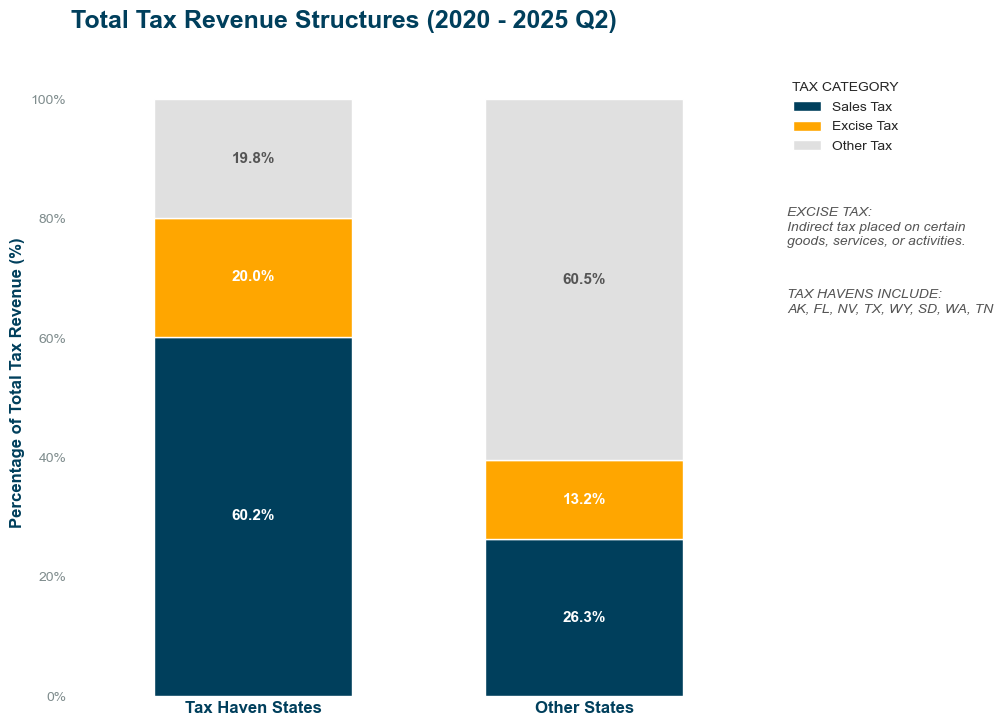

In [74]:
# 1. Prepare numerical data for plotting
# Using 'Total_Revenue', 'Sales_Amt', and 'Excise_Amt' from your established 'grouped' variable
plot_data = grouped.copy()
plot_data['Sales Tax'] = (plot_data['Sales_Amt'] / plot_data['Total_Revenue']) * 100
plot_data['Excise Tax'] = (plot_data['Excise_Amt'] / plot_data['Total_Revenue']) * 100
plot_data['Other Tax'] = (plot_data['Other_Tax_Amt'] / plot_data['Total_Revenue']) * 100

# SWAP ORDER: Place Tax Haven States on the left
plot_data = plot_data.reindex(['Tax Haven States', 'Other States'])

# Set clean aesthetic style
sns.set_style("white")
plt.rcParams['font.family'] = 'sans-serif'

# 2. Define your specific corporate highlight palette
colors = ['#003f5c', '#ffa600', '#e0e0e0']

# 3. Create the Visualization
ax = plot_data[['Sales Tax', 'Excise Tax', 'Other Tax']].plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=colors,
    edgecolor='white',
    width=0.6
)

# 4. Refine Formatting (Y-axis numbers are kept as requested)
plt.title('Total Tax Revenue Structures (2020 - 2025 Q2)',
          fontsize=18, fontweight='bold', pad=30, loc='left', color='#003f5c')

plt.ylabel('Percentage of Total Tax Revenue (%)', fontsize=12, fontweight='bold', color='#003f5c')
plt.yticks(range(0, 101, 20), [f'{i}%' for i in range(0, 101, 20)], fontsize=10, color='#7f8c8d')
plt.xlabel('')
plt.xticks(rotation=0, fontsize=12, fontweight='bold', color='#003f5c')

# Remove top and right spines for a modern dashboard look
sns.despine(top=True, right=True, left=False, bottom=False)

# 5. Add Data Labels with Legibility Logic
n_groups = len(plot_data)
for i, p in enumerate(ax.patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 5:
        # White text for dark blue/gold segments, and dark gray for the light gray segment
        label_color = 'white' if i < (n_groups * 2) else '#555555'
        ax.text(x + width/2, y + height/2, f'{height:.1f}%',
                ha='center', va='center', color=label_color,
                fontweight='bold', fontsize=11)

# 6. Custom Legend and requested sub-notes
# Create the legend first
leg = plt.legend(title='TAX CATEGORY', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

# Place the required explanations directly under the legend box
plt.text(1.03, 0.78, "EXCISE TAX:\nIndirect tax placed on certain\ngoods, services, or activities.",
         transform=ax.transAxes, fontsize=10, color='#555555', style='italic', va='top')

plt.text(1.03, 0.65, "TAX HAVENS INCLUDE:\nAK, FL, NV, TX, WY, SD, WA, TN",
         transform=ax.transAxes, fontsize=10, color='#555555', style='italic', va='top')

plt.tight_layout(rect=[0, 0.03, 0.85, 0.95]) # Adjust layout to ensure side text is visible
plt.show()